## Dataset format for Influpaint
The dataset is a xarray object stored as netcdf on disk. It has dimensions `(sample, feature, date, place)` where date and place are padded to have dimension 64.
- dates are Saturdays
- places are location from Flusight data locations. The sum of all places (whole U.S) is not included at that stage
- samples are integers


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import xarray as xr
from season_setup import SeasonSetup
import build_dataset
import epiweeks
import warnings
season_setup = SeasonSetup.from_flusight(fluseason_startdate=pd.to_datetime("2020-08-01"), 
                                        remove_territories=True, remove_us=True)

download=False
if download:
    write=True
else:
    write=False

No season nor file provided, loading 2022-2023 locations information
Spatial Setup with 51 locations, with a season start_date of Aug 01


## 0. Read NC data
> The hospital admission data are a subset of the ILI data as those admitted will present with ILI in the ED first and then counted again when admitted. I’ve also been told the admission date generally occurs on the same date as the ED visit.
> ve also added the only PHE-positive test data available. They provide the last 52 weeks on a rolling basis. The historical data is unavailable at this time, and further discussions may be needed to gain access. Again, these data are confirmed (positive test) infections conducted by the hospital-based Public Health Epidemiologist (PHE) program.
 
> *Public Health Epidemiologists Program*
> In 2003, DPH created a hospital-based Public Health Epidemiologist (PHE) program to strengthen coordination and communication between hospitals, health departments and the state. The PHE program covers approximately 38 percent of general/acute care beds and 40 percent of ED visits in the state. PHEs play a critical role in assuring routine and urgent communicable disease control, hospital reporting of communicable diseases, outbreak management and case finding during community wide outbreaks.

week_enddate           location_code  value  fluseason_fraction  \
0      2010-01-02       NC_Influenza_hosp     31            0.419178   
1      2010-01-09       NC_Influenza_hosp     19            0.438356   
2      2010-01-16       NC_Influenza_hosp     15            0.457534   
3      2010-01-23       NC_Influenza_hosp     20            0.476712   
4      2010-01-30       NC_Influenza_hosp     14            0.495890   
...           ...                     ...    ...                 ...   
3014   2023-07-01  NC_RSV-like Illness_ed     97            0.912329   
3015   2023-07-08  NC_RSV-like Illness_ed     91            0.931507   
3016   2023-07-15  NC_RSV-like Illness_ed     86            0.950685   
3017   2023-07-22  NC_RSV-like Illness_ed     90            0.969863   
3018   2023-07-29  NC_RSV-like Illness_ed     89            0.989041   

      fluseason  season_week  epiweek  
0          2009           23       52  
1          2009           24        1  
2          2009           25        2  
3          2009           26        3  
4          2009           27        4  
...         ...          ...      ...  
3014       2022           48       26  
3015       2022           49       27  
3016       2022           50       28  
3017       2022           51       29  
3018       2022           52       30  

[2836 rows x 7 columns]

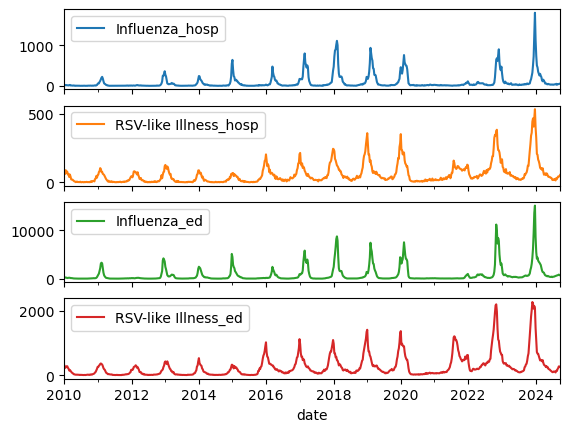

In [2]:
hosp_now = pd.read_csv("custom_datasets/weekly_hosps_2010_24.csv", parse_dates=["Week Date"])
hosp_now["date"] = hosp_now["Week Date"]
hosp_now = hosp_now.set_index("date").drop("Week Date", axis=1)

nc_ed =  pd.read_csv("custom_datasets/weekly_ED_Visits_2010_24.csv", parse_dates=["Week Date"])
nc_ed["date"] = nc_ed["Week Date"]
nc_ed = nc_ed.set_index("date").drop("Week Date", axis=1)

nc_payload = pd.merge(hosp_now, nc_ed, on="date", how="outer", suffixes=("_hosp", "_ed"))


# drop the column whose name contains covid
nc_payload = nc_payload[[col for col in nc_payload.columns if "covid" not in col.lower()]]
nc_payload.plot(subplots=True)

# tidy the dataframe by putting the data in long format
nc_payload = nc_payload.reset_index().melt(id_vars=["date"], var_name="location_code", value_name="value")
nc_payload = nc_payload.rename(columns={"date":"week_enddate"})

# add the fluseason column and the fluseason_fraction column
nc_payload = nc_payload.assign(fluseason_fraction=nc_payload["week_enddate"].apply(season_setup.get_fluseason_fraction))
nc_payload = nc_payload.assign(fluseason=   nc_payload["week_enddate"].apply(season_setup.get_fluseason_year))
nc_payload = nc_payload.assign(season_week= nc_payload["week_enddate"].apply(season_setup.get_fluseason_week))
nc_payload = nc_payload.assign(epiweek=nc_payload["week_enddate"].apply(lambda x: epiweeks.Week.fromdate(x).week))
# add NC to what is already in the location column
nc_payload["location_code"] = "NC_" + nc_payload["location_code"]

# remoove the 2024 season
nc_payload = nc_payload[nc_payload["fluseason"] != 2024]
nc_payload = nc_payload[nc_payload["fluseason"] != 2023] # remove the 2023 season because we test on that for the paper
nc_payload

In [3]:
nc_payload

week_enddate           location_code  value  fluseason_fraction  \
0      2010-01-02       NC_Influenza_hosp     31            0.419178   
1      2010-01-09       NC_Influenza_hosp     19            0.438356   
2      2010-01-16       NC_Influenza_hosp     15            0.457534   
3      2010-01-23       NC_Influenza_hosp     20            0.476712   
4      2010-01-30       NC_Influenza_hosp     14            0.495890   
...           ...                     ...    ...                 ...   
3014   2023-07-01  NC_RSV-like Illness_ed     97            0.912329   
3015   2023-07-08  NC_RSV-like Illness_ed     91            0.931507   
3016   2023-07-15  NC_RSV-like Illness_ed     86            0.950685   
3017   2023-07-22  NC_RSV-like Illness_ed     90            0.969863   
3018   2023-07-29  NC_RSV-like Illness_ed     89            0.989041   

      fluseason  season_week  epiweek  
0          2009           23       52  
1          2009           24        1  
2          2009           25        2  
3          2009           26        3  
4          2009           27        4  
...         ...          ...      ...  
3014       2022           48       26  
3015       2022           49       27  
3016       2022           50       28  
3017       2022           51       29  
3018       2022           52       30  

[2836 rows x 7 columns]

In [4]:
fluview = build_dataset.get_from_epidata(
    dataset="fluview", season_setup=season_setup, download=False, write=False
)
fluview
# add season_week and epiweek to fluview
fluview = fluview.assign(season_week=fluview["week_enddate"].apply(season_setup.get_fluseason_week))
fluview = fluview.assign(epiweek=fluview["week_enddate"].apply(lambda x: epiweeks.Week.fromdate(x).week))
fluview

RAW Dataset fluview has 56403 data points, with 52 locations,and NA values: 0, NA locations: 25569
 >>> after clean: Dataset 30834 data points, with 51 locations,and NA values: 0, NA locations: 0


week_enddate location_code    value  fluseason  fluseason_fraction  \
24120   2010-10-09            01  2.13477       2010            0.186301   
24121   2010-10-16            01  2.05999       2010            0.205479   
24122   2010-10-23            01  1.94224       2010            0.224658   
24123   2010-10-30            01  2.27650       2010            0.243836   
24124   2010-11-06            01  2.83371       2010            0.263014   
...            ...           ...      ...        ...                 ...   
56398   2022-08-06            36  1.90540       2022            0.010959   
56399   2022-08-13            36  1.75026       2022            0.030137   
56400   2022-08-20            36  1.81204       2022            0.049315   
56401   2022-08-27            36  1.60709       2022            0.068493   
56402   2022-09-03            36  1.55052       2022            0.087671   

       season_week  epiweek  
24120           10       40  
24121           11       41  
24122           12       42  
24123           13       43  
24124           14       44  
...            ...      ...  
56398            1       31  
56399            2       32  
56400            3       33  
56401            4       34  
56402            5       35  

[30834 rows x 7 columns]

In [9]:
import tqdm
def build_frames(dict_of_dfs):
    combined_df = merge_datasets(dict_of_dfs)
    # Get unique seasons and locations
    seasons = sorted(combined_df['fluseason'].unique())
    location_codes = combined_df.location_code.unique()
    all_frames = []
    for season in tqdm.tqdm(seasons, desc="Building frames", total=len(seasons)):
        
        season_df = combined_df[(combined_df['fluseason'] == season)]
        n_repeat_location_in_season = season_df.groupby("location_code")["dataset_name"].nunique()
        for i in range(n_repeat_location_in_season.max()):
            new_frames = []
            for location in location_codes:
                frame = season_df[season_df["location_code"] == location].sort_values('season_week')
                # this frame can either be empty, or contain one dataset, or severa dataset
                if len(frame) == 0:
                    # Find a random frame from another season for this location
                    alternative_frames = combined_df[
                        (combined_df['location_code'] == location)
                    ]
                    # sample a season in location_df.fluseason.unique()
                    alternative_season = np.random.choice(alternative_frames.fluseason.unique())
                    frame = combined_df[(combined_df['fluseason'] == alternative_season) & (combined_df['location_code'] == location)]
                
                # check if there are multiple datasets in the frame
                n_datasets = frame["dataset_name"].nunique()
                # if ther is several dataset, take the ith dataset in the list of sorted unique dataset names
                if n_datasets > 1:
                    dataset_names = sorted(frame["dataset_name"].unique())
                    frame = frame[frame["dataset_name"] == dataset_names[i%n_datasets]]
                
                #frame = frame.drop(["fluseason", "dataset_name"], axis=1)
                # we now have a frame with only one dataset, we enture it has 53 weeks
                frame = pad_single_frame(frame, location)
                if frame.shape[0] != 53:
                    print (f"Frame for location {location} in season {season} has {frame.shape[0]} weeks")
                    print(frame)
                new_frames.append(frame)
            new_frames = pd.concat(new_frames)#.pivot(index="location_code", columns="season_week", values="value")
            all_frames.append(new_frames)
    return all_frames

def build_frames2(dict_of_dfs):
    return None
    combined_df = merge_datasets(dict_of_dfs)
    # Get unique seasons and locations
    seasons = sorted(combined_df['fluseason'].unique())
    location_codes = combined_df.location_code.unique()
    final_frames = []
    min_location_frames = 3

    for season in seasons:
        season_frames = []
        
        for location in location_codes:
            # Extract frames for this season and location
            frame = combined_df[
                (combined_df['fluseason'] == season) & 
                (combined_df['location_code'] == location)
            ].sort_values('season_week')
            
            # Handle incomplete frames
            if len(frame) == 0:
                # Find a random frame from another season for this location
                alternative_frames = combined_df[
                    (combined_df['location_code'] == location)
                ]
                
                if len(alternative_frames) > 0:
                    frame = alternative_frames.sample(n=1)
                else:
                    # Skip if no alternative found
                    continue
            
            # Pad/fill frame to ensure 53 weeks
            full_frame = pd.DataFrame({
                'season_week': range(1, 54),
                'location_code': location,
                'fluseason': season
            })
            
            # Merge with existing data
            merged_frame = full_frame.merge(
                frame, 
                on=['season_week', 'location_code', 'fluseason'], 
                how='left'
            )
            
            # Track missing weeks before forward fill
            missing_weeks_before = merged_frame['value'].isna().sum()
            
            # Forward fill missing middle weeks
            if missing_weeks_before > 0:
                # Determine if missing weeks are at the extremities or in the middle
                first_valid = merged_frame['value'].first_valid_index()
                last_valid = merged_frame['value'].last_valid_index()
                
                # Identify middle missing weeks
                middle_missing_mask = merged_frame['value'].isna() & \
                    (merged_frame.index > first_valid) & \
                    (merged_frame.index < last_valid)
                
                # Only forward fill middle missing weeks
                merged_frame.loc[middle_missing_mask, 'value'] = \
                    merged_frame.loc[middle_missing_mask, 'value'].fillna(method='ffill')
                
                # Count of actually forward-filled weeks (in the middle)
                middle_missing_weeks = middle_missing_mask.sum()
                
                if middle_missing_weeks > 0:
                    warnings.warn(
                        f"Season {season}, Location {location}: "
                        f"{middle_missing_weeks} middle weeks forward-filled"
                    )
            
            # Pad extremities with zeros
            merged_frame['value'] = merged_frame['value'].fillna(0)
            
            season_frames.append(merged_frame)
        
        # Ensure we have at least min_location_frames
        if len(season_frames) < min_location_frames:
            # Duplicate this season's data to meet minimum requirement
            while len(season_frames) < min_location_frames:
                season_frames.extend(season_frames)
        
        final_frames.extend(season_frames)
    return final_frames



def pad_single_frame(frame, location):
    """
    Pad a single frame with missing weeks.
    """

    # we want frame.season_week to be from 1 to 53 so we need to fill the gaps
    # we fill external gap with 0 and internal gap with the previous value
    min_week = frame["season_week"].min()
    max_week = frame["season_week"].max()
    all_weeks = set(range(1, 54))
    missing_weeks = all_weeks - set(frame["season_week"])
    # sort the missing weeks
    missing_weeks = sorted(list(missing_weeks))
    if len(missing_weeks) > 0:
        pass
        #print(f"Missing weeks for location {location} in season {season}: {missing_weeks}")
    for week in missing_weeks:
        if week <= min_week or week >= max_week:
            new_value = 0
        else:
            previous_week = frame[frame["season_week"] == week-1]
            new_value = previous_week["value"].values[0]

        new_frame = pd.DataFrame({
                                "season_week":[week], 
                                "location_code":[location], 
                                "value":[new_value], 
                                #"dataset_name": [frame["dataset_name"].unique()[0]]
                                },)
        frame = pd.concat([frame, new_frame])
        

    return frame.reset_index(drop=True)
    


def merge_datasets(dict_of_dfs):
    """
    Merges the datasets in the dict_of_dfs dictionary into a single dataframe.
    The keys of the dictionary are the dataset names and the values are dictionaries
    with keys "df" and "multiplier". The "df" key contains the dataframe and the "multiplier"
    key contains the number of times the dataframe should be repeated in the final dataframe.
    """

    # Combine all input dataframes with their multipliers
    combined_datasets = []
    for dataset_name, dataset_info in dict_of_dfs.items():
        df = dataset_info['df'].copy()
        multiplier = dataset_info['multiplier']
        
        # Ensure required columns exist
        required_columns = ['season_week', 'location_code', 'value', 'fluseason', "week_enddate"]
        for col in required_columns:
            if col not in df.columns:
                raise ValueError(f"Missing required column: {col}")
            
        df = df[required_columns]
        for i in range(multiplier):
            df_copy = df.copy()
            df_copy.loc[:,"dataset_name"] = dataset_name + "_" + str(i)
            df_copy.loc[:,"fluseason"] = df_copy.loc[:,"fluseason"] + i*10000
            combined_datasets.append(df_copy)

    combined_df = pd.concat(combined_datasets, ignore_index=True)

    return combined_df


In [6]:
netcdf_file = (
    "Flusight/flu-datasets/synthetic/CSP_FluSMHR1_weekly_padded_4scn.nc"
)
channels = 1
flu_dyn = xr.open_dataarray(netcdf_file)
flu_dyn = flu_dyn.sel(feature="incidH_FluA") + flu_dyn.sel(
    feature="incidH_FluB"
)

<xarray.DataArray 'sample' (sample: 1199)>
array([   0,    1,    2, ..., 1196, 1197, 1198])
Coordinates:
  * sample   (sample) int64 0 1 2 3 4 5 6 ... 1192 1193 1194 1195 1196 1197 1198

In [12]:
smh_df = []
for i, s in enumerate(flu_dyn.sample[:200]):
    df = flu_dyn.sel(sample=s).to_dataframe(name='value').reset_index()
    df["fluseason"] = i
    smh_df.append(df)

smh_df = pd.concat(smh_df)
# remove NaT values from "date" and empty location_code
smh_df = smh_df.dropna(subset=["date"])
# remove empty string from location_code
smh_df = smh_df[smh_df["place"] != ""]

smh_df = smh_df.rename(columns={"place": "location_code", "date": "week_enddate"})
# keep just the first two letter of location_code
smh_df["location_code"] = smh_df["location_code"].apply(lambda x: x[:2])

smh_df = smh_df.assign(fluseason_fraction=smh_df["week_enddate"].apply(season_setup.get_fluseason_fraction))
# smh_df = smh_df.assign(fluseason=   smh_df["week_enddate"].apply(season_setup.get_fluseason_year))
smh_df = smh_df.assign(epiweek=smh_df["week_enddate"].apply(lambda x: epiweeks.Week.fromdate(x).week))
smh_df = smh_df.assign(season_week=smh_df["week_enddate"].apply(season_setup.get_fluseason_week))

smh_df

week_enddate location_code  sample     value  fluseason  \
0      2022-07-24            01       0  0.000000          0   
1      2022-07-24            02       0  0.000000          0   
2      2022-07-24            04       0  0.000000          0   
3      2022-07-24            05       0  0.000000          0   
4      2022-07-24            06       0  0.000000          0   
...           ...           ...     ...       ...        ...   
2990   2023-06-11            51     199  2.184665        199   
2991   2023-06-11            53     199  7.386945        199   
2992   2023-06-11            54     199  0.098056        199   
2993   2023-06-11            55     199  1.205922        199   
2994   2023-06-11            56     199  0.085390        199   

      fluseason_fraction  epiweek  season_week  
0               0.975342       30           52  
1               0.975342       30           52  
2               0.975342       30           52  
3               0.975342       30           52  
4               0.975342       30           52  
...                  ...      ...          ...  
2990            0.857534       24           45  
2991            0.857534       24           45  
2992            0.857534       24           45  
2993            0.857534       24           45  
2994            0.857534       24           45  

[479400 rows x 8 columns]

In [ ]:
# The goal is to build a dataset as an array
# (n_samples, n_features, n_dates, n_places)
# the multiplier is used to create multiple datasets from the same data,
# which increases the weight of a particular dataset
dict_of_dfs = {
    "nc_payload": {"df":nc_payload, "multiplier":1}, 
    "fluview": {"df":fluview, "multiplier":30},
    "smh_df": {"df":smh_df, "multiplier":1}
    }

combined_df = merge_datasets(dict_of_dfs)
final_frames = build_frames(dict_of_dfs)
seasons = sorted(combined_df['fluseason'].unique())
location_codes = combined_df.location_code.unique()
print(f"generated {len(final_frames)} frames from {len(seasons)} seasons and {len(location_codes)} locations in datasets {dict_of_dfs.keys()}")

Building frames:   8%|▊         | 49/591 [00:23<04:31,  2.00it/s]

In [ ]:
import season_setup
season_setup =season_setup.SeasonSetup.from_flusight(fluseason_startdate=pd.to_datetime("2020-08-01"), 
                                        remove_territories=True, remove_us=True)

No season nor file provided, loading 2022-2023 locations information
Spatial Setup with 51 locations, with a season start_date of Aug 01


In [ ]:
new_locations = pd.DataFrame({
    "location_code": sorted(location_codes),
})

# Ensure location_code is of type string
new_locations['location_code'] = new_locations['location_code'].astype(str)

# Merge with season_setup.locations_df to get the location names
new_locations = new_locations.merge(season_setup.locations_df, 
                                    on='location_code',
                                    how='left')

# Fill missing location names with the location code
new_locations['location_name'] = new_locations['location_name'].fillna(new_locations['location_code'])

new_locations = new_locations[['location_code', 'location_name']]



location_code abbreviation             location_name  \
0                         01           AL                   Alabama   
1                         02           AK                    Alaska   
2                         04           AZ                   Arizona   
3                         05           AR                  Arkansas   
4                         06           CA                California   
5                         08           CO                  Colorado   
6                         09           CT               Connecticut   
7                         10           DE                  Delaware   
8                         11           DC      District of Columbia   
9                         12           FL                   Florida   
10                        13           GA                   Georgia   
11                        15           HI                    Hawaii   
12                        16           ID                     Idaho   
13                        17           IL                  Illinois   
14                        18           IN                   Indiana   
15                        19           IA                      Iowa   
16                        20           KS                    Kansas   
17                        21           KY                  Kentucky   
18                        22           LA                 Louisiana   
19                        23           ME                     Maine   
20                        24           MD                  Maryland   
21                        25           MA             Massachusetts   
22                        26           MI                  Michigan   
23                        27           MN                 Minnesota   
24                        28           MS               Mississippi   
25                        29           MO                  Missouri   
26                        30           MT                   Montana   
27                        31           NE                  Nebraska   
28                        32           NV                    Nevada   
29                        33           NH             New Hampshire   
30                        34           NJ                New Jersey   
31                        35           NM                New Mexico   
32                        36           NY                  New York   
33                        37           NC            North Carolina   
34                        38           ND              North Dakota   
35                        39           OH                      Ohio   
36                        40           OK                  Oklahoma   
37                        41           OR                    Oregon   
38                        42           PA              Pennsylvania   
39                        44           RI              Rhode Island   
40                        45           SC            South Carolina   
41                        46           SD              South Dakota   
42                        47           TN                 Tennessee   
43                        48           TX                     Texas   
44                        49           UT                      Utah   
45                        50           VT                   Vermont   
46                        51           VA                  Virginia   
47                        53           WA                Washington   
48                        54           WV             West Virginia   
49                        55           WI                 Wisconsin   
50                        56           WY                   Wyoming   
51           NC_Influenza_ed          NaN           NC_Influenza_ed   
52         NC_Influenza_hosp          NaN         NC_Influenza_hosp   
53    NC_RSV-like Illness_ed          NaN    NC_RSV-like Illness_ed   
54  NC_RSV-like Illness_hosp          NaN  NC_RSV-like Illness_hosp   

    population  geoid  
0    5039877.0

In [72]:
season_setup.update_locations(new_locations)

In [91]:
# reload tjhe build_dataset module
importlib.reload(build_dataset)


<module 'build_dataset' from '/Users/chadi/Research/influpaint/build_dataset.py'>

In [93]:
pd.concat(final_frames)

season_week      location_code  value  fluseason week_enddate  \
0             1  NC_Influenza_hosp    3.0          0   2010-08-07   
1             2  NC_Influenza_hosp    1.0          0   2010-08-14   
2             3  NC_Influenza_hosp    0.0          0   2010-08-21   
3             4  NC_Influenza_hosp    1.0          0   2010-08-28   
4             5  NC_Influenza_hosp    1.0          0   2010-09-04   
..          ...                ...    ...        ...          ...   
48           49                 36    0.0        426          NaT   
49           50                 36    0.0        426          NaT   
50           51                 36    0.0        426          NaT   
51           52                 36    0.0        426          NaT   
52           53                 36    0.0        426          NaT   

    dataset_name  
0   nc_payload_0  
1   nc_payload_0  
2   nc_payload_0  
3   nc_payload_0  
4   nc_payload_0  
..           ...  
48           NaN  
49           NaN  
50           NaN  
51           NaN  
52           NaN  

[1244705 rows x 6 columns]

In [92]:
array_list = build_dataset.dataframe_to_arraylist(df=pd.concat(final_frames), season_setup=season_setup)

In [97]:
["f"] * 10

['f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f']

In [100]:
# save as an netcdf file
array = np.array(array_list)

flu_payload_array = xr.DataArray(array, 
                coords={'sample': np.arange(array.shape[0]),
                    'feature': np.arange(array.shape[1]),
                    'season_week': np.arange(1, array.shape[2]+1),
                    'place': season_setup.locations + [""]*(array.shape[3] - len(season_setup.locations))}, 
                dims=["sample", "feature", "season_week", "place"])

In [102]:
flu_payload_array.to_netcdf("flu_payload_array.nc")

Commands to sync Flu SMH R1 from s3 bucket
```bash
aws s3 sync s3://idd-inference-runs/USA-20220923T154311/model_output/ datasets/SMH_R1/SMH_R1_lowVac_optImm_2022 --exclude "*" --include "hosp*/final/*"
aws s3 sync s3://idd-inference-runs/USA-20220923T155228/model_output/ datasets/SMH_R1/SMH_R1_lowVac_pesImm_2022 --exclude "*" --include "hosp*/final/*"
aws s3 sync s3://idd-inference-runs/USA-20220923T160106/model_output/ datasets/SMH_R1/SMH_R1_highVac_optImm_2022 --exclude "*" --include "hosp*/final/*"
aws s3 sync s3://idd-inference-runs/USA-20220923T161418/model_output/ datasets/SMH_R1/SMH_R1_highVac_pesImm_2022 --exclude "*" --include "hosp*/final/*"
```
and take a humidity file from the config


KeyError: 'fluseason_week'

season_week      location_code  value  fluseason week_enddate  \
0             1  NC_Influenza_hosp    3.0          0   2010-08-07   
1             2  NC_Influenza_hosp    1.0          0   2010-08-14   
2             3  NC_Influenza_hosp    0.0          0   2010-08-21   
3             4  NC_Influenza_hosp    1.0          0   2010-08-28   
4             5  NC_Influenza_hosp    1.0          0   2010-09-04   
..          ...                ...    ...        ...          ...   
48           49                 36    0.0        426          NaT   
49           50                 36    0.0        426          NaT   
50           51                 36    0.0        426          NaT   
51           52                 36    0.0        426          NaT   
52           53                 36    0.0        426          NaT   

    dataset_name  
0   nc_payload_0  
1   nc_payload_0  
2   nc_payload_0  
3   nc_payload_0  
4   nc_payload_0  
..           ...  
48           NaN  
49           NaN  
50           NaN  
51           NaN  
52           NaN  

[1244705 rows x 6 columns]

In [76]:
for i, frame in enumerate(final_frames):
    df = final_frames[i]
    df["fluseason"] = i
    final_frames[i] = df

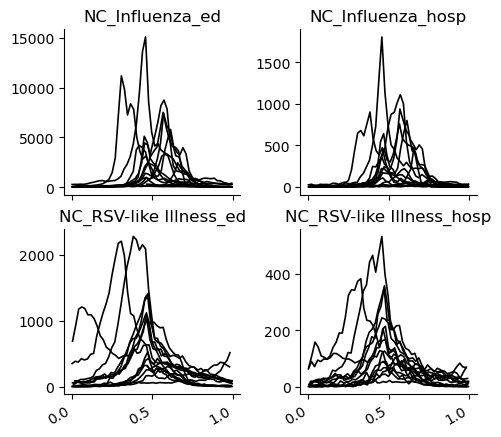

In [30]:
import seaborn as sns
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(5,5))
nc_payload_piv = nc_payload.pivot(columns='location_code', values='value', index=["fluseason", "fluseason_fraction"])
for idx, pl in enumerate(nc_payload_piv.columns):
    for year in nc_payload_piv.index.unique(level='fluseason'):
        ax = axes.flat[idx]
        ax.plot(nc_payload_piv.loc[year, pl], c='k', lw=1.2)
        ax.set_title(pl)
    #ax.grid()
    sns.despine(ax=ax)
fig.tight_layout()
fig.autofmt_xdate()

In [31]:
build_dataset.dataframe_to_arraylist(nc_payload, season_setup = season_setup, value_column='value')

KeyError: "None of [Index(['01', '02', '04', '05', '06', '08', '09', '10', '11', '12', '13', '15',\n       '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27',\n       '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',\n       '40', '41', '42', '44', '45', '46', '47', '48', '49', '50', '51', '53',\n       '54', '55', '56'],\n      dtype='object', name='location_code')] are in the [columns]"

## 1. FluSight dataset (= Ground-truth data for inpainting)

Make sure my fork is synced, then
```bash
./update_data.sh
```
Locations are always ordered like this dataframe:

In [2]:
flusight22 = build_dataset.get_from_epidata(dataset="flusight2022_23", 
                                            season_setup=season_setup, 
                                            write=False,
                                            clean=False)
flusight22

⚠️ ⚠️ ⚠️ If during season, make sure ./update_data.sh has been run
RAW Dataset flusight2022_23 has 10442 data points, with 54 locations,and NA values: 0, NA locations: 0


location  value week_enddate location_code   location_name abbreviation  \
0           01      0   2020-01-11            01         Alabama           AL   
1           01      0   2020-01-18            01         Alabama           AL   
2           01      0   2020-01-25            01         Alabama           AL   
3           01      0   2020-02-01            01         Alabama           AL   
4           01      0   2020-02-08            01         Alabama           AL   
...        ...    ...          ...           ...             ...          ...   
10437       78      0   2023-10-14            78  Virgin Islands           VI   
10438       78      0   2023-10-21            78  Virgin Islands           VI   
10439       78      0   2023-10-28            78  Virgin Islands           VI   
10440       78      0   2023-11-04            78  Virgin Islands           VI   
10441       78      0   2023-11-11            78  Virgin Islands           VI   

       fluseason  fluseason_fraction  
0           2019            0.490411  
1           2019            0.509589  
2           2019            0.528767  
3           2019            0.547945  
4           2019            0.567123  
...          ...                 ...  
10437       2023            0.246575  
10438       2023            0.265753  
10439       2023            0.284932  
10440       2023            0.304110  
10441       2023            0.323288  

[10442 rows x 8 columns]

In [3]:
# Flusight 2023 does not have data for the Virgin Islands (78) so the clean=True flag will remove it.
flusight23 = build_dataset.get_from_epidata(dataset="flusight2023_24", 
                                            season_setup=season_setup, 
                                            write=False,
                                            clean=True)
flusight23

⚠️ ⚠️ ⚠️ If during season, make sure ./update_data.sh has been run
RAW Dataset flusight2023_24 has 6149 data points, with 54 locations,and NA values: 1, NA locations: 0
 >>> after clean: Dataset 6148 data points, with 53 locations,and NA values: 0, NA locations: 0


week_enddate location_code  value  fluseason  fluseason_fraction
0      2024-04-27            02    3.0     2023.0            0.783562
1      2024-04-20            02    2.0     2023.0            0.764384
2      2024-04-13            02    8.0     2023.0            0.745205
3      2024-04-06            02    7.0     2023.0            0.726027
4      2024-03-30            02    8.0     2023.0            0.706849
...           ...           ...    ...        ...                 ...
6143   2022-03-12            56    6.0     2021.0            0.654795
6144   2022-03-05            56    4.0     2021.0            0.635616
6145   2022-02-26            56    4.0     2021.0            0.616438
6146   2022-02-19            56    2.0     2021.0            0.597260
6147   2022-02-12            56    2.0     2021.0            0.578082

[6148 rows x 5 columns]

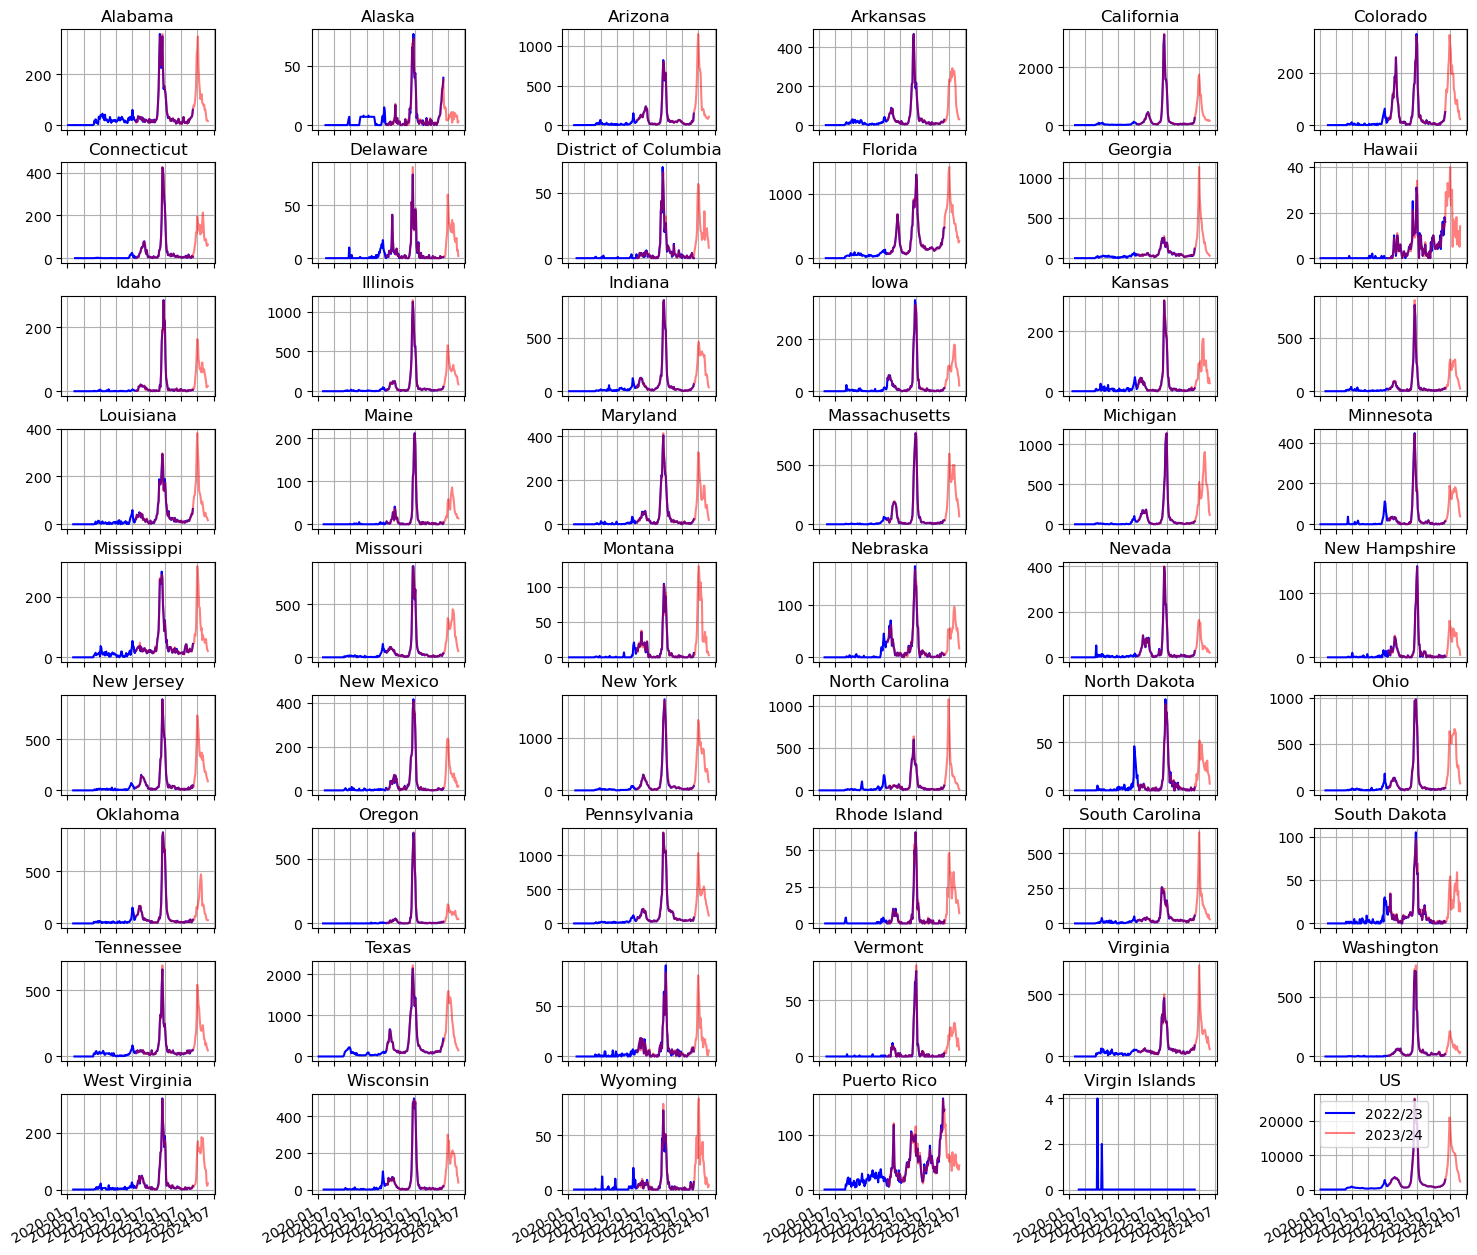

In [4]:
fig, axes = plt.subplots(9, 6, sharex=True, figsize=(15,15))
flusight22_piv  = flusight22.pivot(index = "week_enddate", columns='location_code', values='value')
flusight23_piv  = flusight23.pivot(index = "week_enddate", columns='location_code', values='value')
for idx, pl in enumerate(flusight22_piv.columns):
    ax = axes.flat[idx]
    ax.plot(flusight22_piv[pl], color='blue', label='2022/23')
    if pl in flusight23_piv.columns:
        ax.plot(flusight23_piv[pl], color='red', label='2023/24', alpha=0.5)
    ax.set_title(season_setup.get_location_name(pl))
    ax.grid()
ax.legend()
fig.tight_layout()
fig.autofmt_xdate()

In [2]:
gt_xarr = build_dataset.dataframe_to_xarray(df, season_setup=season_setup, 
            xarray_name = "gt_flusight_incidHosp", 
            xarrax_features = "incidHosp")
print(gt_xarr.shape)
gt_xarr.to_netcdf(f"Flusight/flu-datasets/{gt_xarr.name}_padded.nc")

NameError: name 'df' is not defined

This data is on saturday for 53 locations + US

## 3. Delphi-epidata Flusurv

In [22]:
flusurv = build_dataset.get_from_epidata(dataset="flusurv",
                                        season_setup=season_setup, 
                                        download=download, 
                                        write=write,
                                        clean=False)

 >> summing NY_albany and NY_rochester into NY
RAW Dataset flusurv has 7633 data points, with 55 locations,and NA values: 36, NA locations: 1190


In [4]:
flusurv

release_date location     issue   epiweek    lag  rate_age_0  rate_age_1  \
0      2017-02-07       CA  201704.0  200340.0  695.0         0.0         0.0   
1      2017-02-07       CA  201704.0  200341.0  694.0         0.0         0.0   
2      2017-02-07       CA  201704.0  200342.0  693.0         0.0         0.0   
3      2017-02-07       CA  201704.0  200343.0  692.0         0.0         0.0   
4      2017-02-07       CA  201704.0  200344.0  691.0         0.0         0.6   
...           ...      ...       ...       ...    ...         ...         ...   
7628          NaN      NaN       NaN       NaN    NaN         NaN         NaN   
7629          NaN      NaN       NaN       NaN    NaN         NaN         NaN   
7630          NaN      NaN       NaN       NaN    NaN         NaN         NaN   
7631          NaN      NaN       NaN       NaN    NaN         NaN         NaN   
7632          NaN      NaN       NaN       NaN    NaN         NaN         NaN   

      rate_age_2  rate_age_3  rate_age_4  rate_overall week_enddate  \
0            NaN         NaN         NaN           0.0   2003-10-04   
1            NaN         NaN         NaN           0.0   2003-10-11   
2            NaN         NaN         NaN           0.0   2003-10-18   
3            NaN         NaN         NaN           0.0   2003-10-25   
4            NaN         NaN         NaN           0.5   2003-11-01   
...          ...         ...         ...           ...          ...   
7628         NaN         NaN         NaN           NaN          NaT   
7629         NaN         NaN         NaN           NaN          NaT   
7630         NaN         NaN         NaN           NaN          NaT   
7631         NaN         NaN         NaN           NaN          NaT   
7632         NaN         NaN         NaN           NaN          NaT   

     location_code   location_name abbreviation  value  fluseason  \
0               06      California           CA    0.0     2003.0   
1               06      California           CA    0.0     2003.0   
2               06      California           CA    0.0     2003.0   
3               06      California           CA    0.0     2003.0   
4               06      California           CA    0.5     2003.0   
...            ...             ...          ...    ...        ...   
7628            54   West Virginia           WV    NaN        NaN   
7629            55       Wisconsin           WI    NaN        NaN   
7630            56         Wyoming           WY    NaN        NaN   
7631            72     Puerto Rico           PR    NaN        NaN   
7632            78  Virgin Islands           VI    NaN        NaN   

      fluseason_fraction  
0               0.219178  
1               0.238356  
2               0.257534  
3               0.276712  
4               0.295890  
...                  ...  
7628                 NaN  
7629                 NaN  
7630                 NaN  
7631                 NaN  
7632                 NaN  

[7633 rows x 18 columns]

In [23]:
flusurv_clean = build_dataset.clean_dataset(flusurv, season_setup=season_setup)
flusurv_clean

 >>> after clean: Dataset 6407 data points, with 18 locations,and NA values: 0, NA locations: 0


week_enddate location_code  value  fluseason  fluseason_fraction
0      2003-10-04            06    0.0     2003.0            0.219178
1      2003-10-11            06    0.0     2003.0            0.238356
2      2003-10-18            06    0.0     2003.0            0.257534
3      2003-10-25            06    0.0     2003.0            0.276712
4      2003-11-01            06    0.5     2003.0            0.295890
...           ...           ...    ...        ...                 ...
7592   2020-03-28            36    0.6     2019.0            0.701370
7593   2020-04-04            36    0.3     2019.0            0.720548
7594   2020-04-11            36    0.1     2019.0            0.739726
7595   2020-04-18            36    0.0     2019.0            0.758904
7596   2020-04-25            36    0.1     2019.0            0.778082

[6407 rows x 5 columns]

In [12]:
flusurv_clean

week_enddate location_code  value  fluseason  fluseason_fraction
0      2003-10-04            06    0.0     2003.0            0.219178
1      2003-10-11            06    0.0     2003.0            0.238356
2      2003-10-18            06    0.0     2003.0            0.257534
3      2003-10-25            06    0.0     2003.0            0.276712
4      2003-11-01            06    0.5     2003.0            0.295890
...           ...           ...    ...        ...                 ...
7592   2020-03-28            36    0.6     2019.0            0.701370
7593   2020-04-04            36    0.3     2019.0            0.720548
7594   2020-04-11            36    0.1     2019.0            0.739726
7595   2020-04-18            36    0.0     2019.0            0.758904
7596   2020-04-25            36    0.1     2019.0            0.778082

[6407 rows x 5 columns]

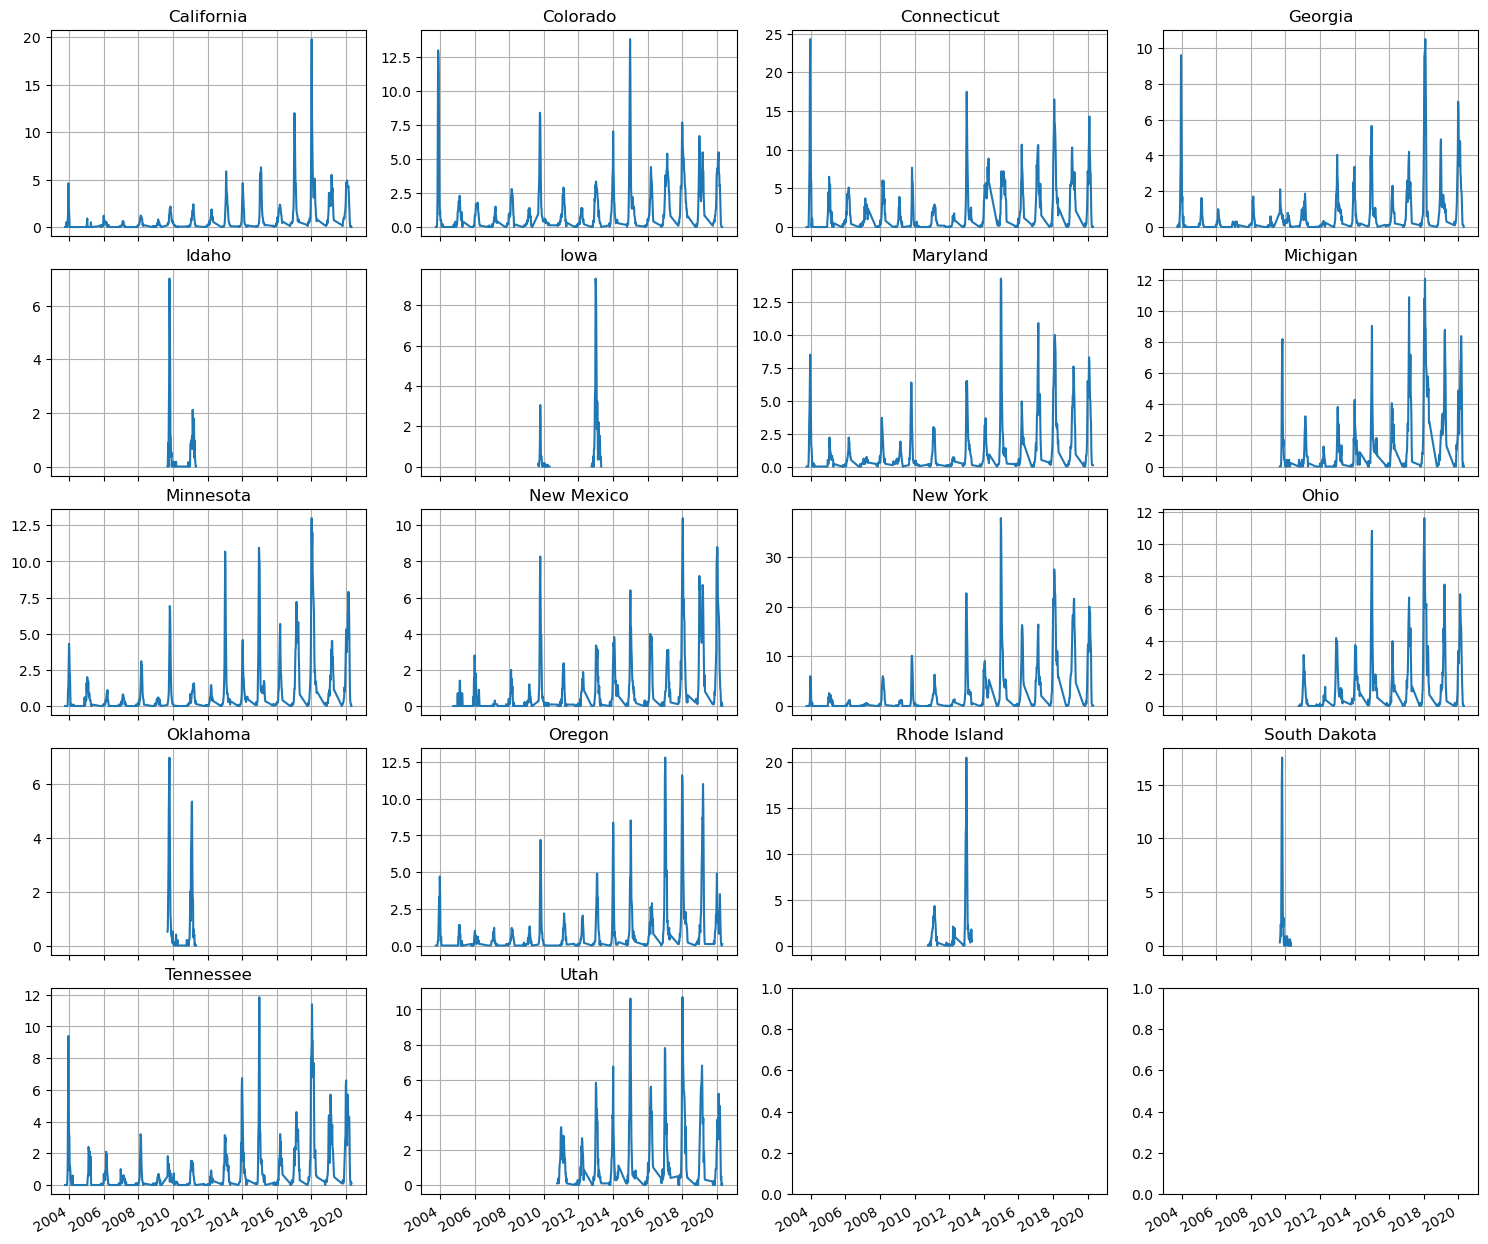

In [11]:
fig, axes = plt.subplots(5, 4, sharex=True, figsize=(15,15))
flusurv_piv  = flusurv_clean.pivot(columns='location_code', values='value', index="week_enddate")
for idx, pl in enumerate(flusurv_piv.columns):
    ax = axes.flat[idx]
    ax.plot(flusurv_piv[pl])
    ax.set_title(season_setup.get_location_name(pl))
    ax.grid()
fig.tight_layout()
fig.autofmt_xdate()

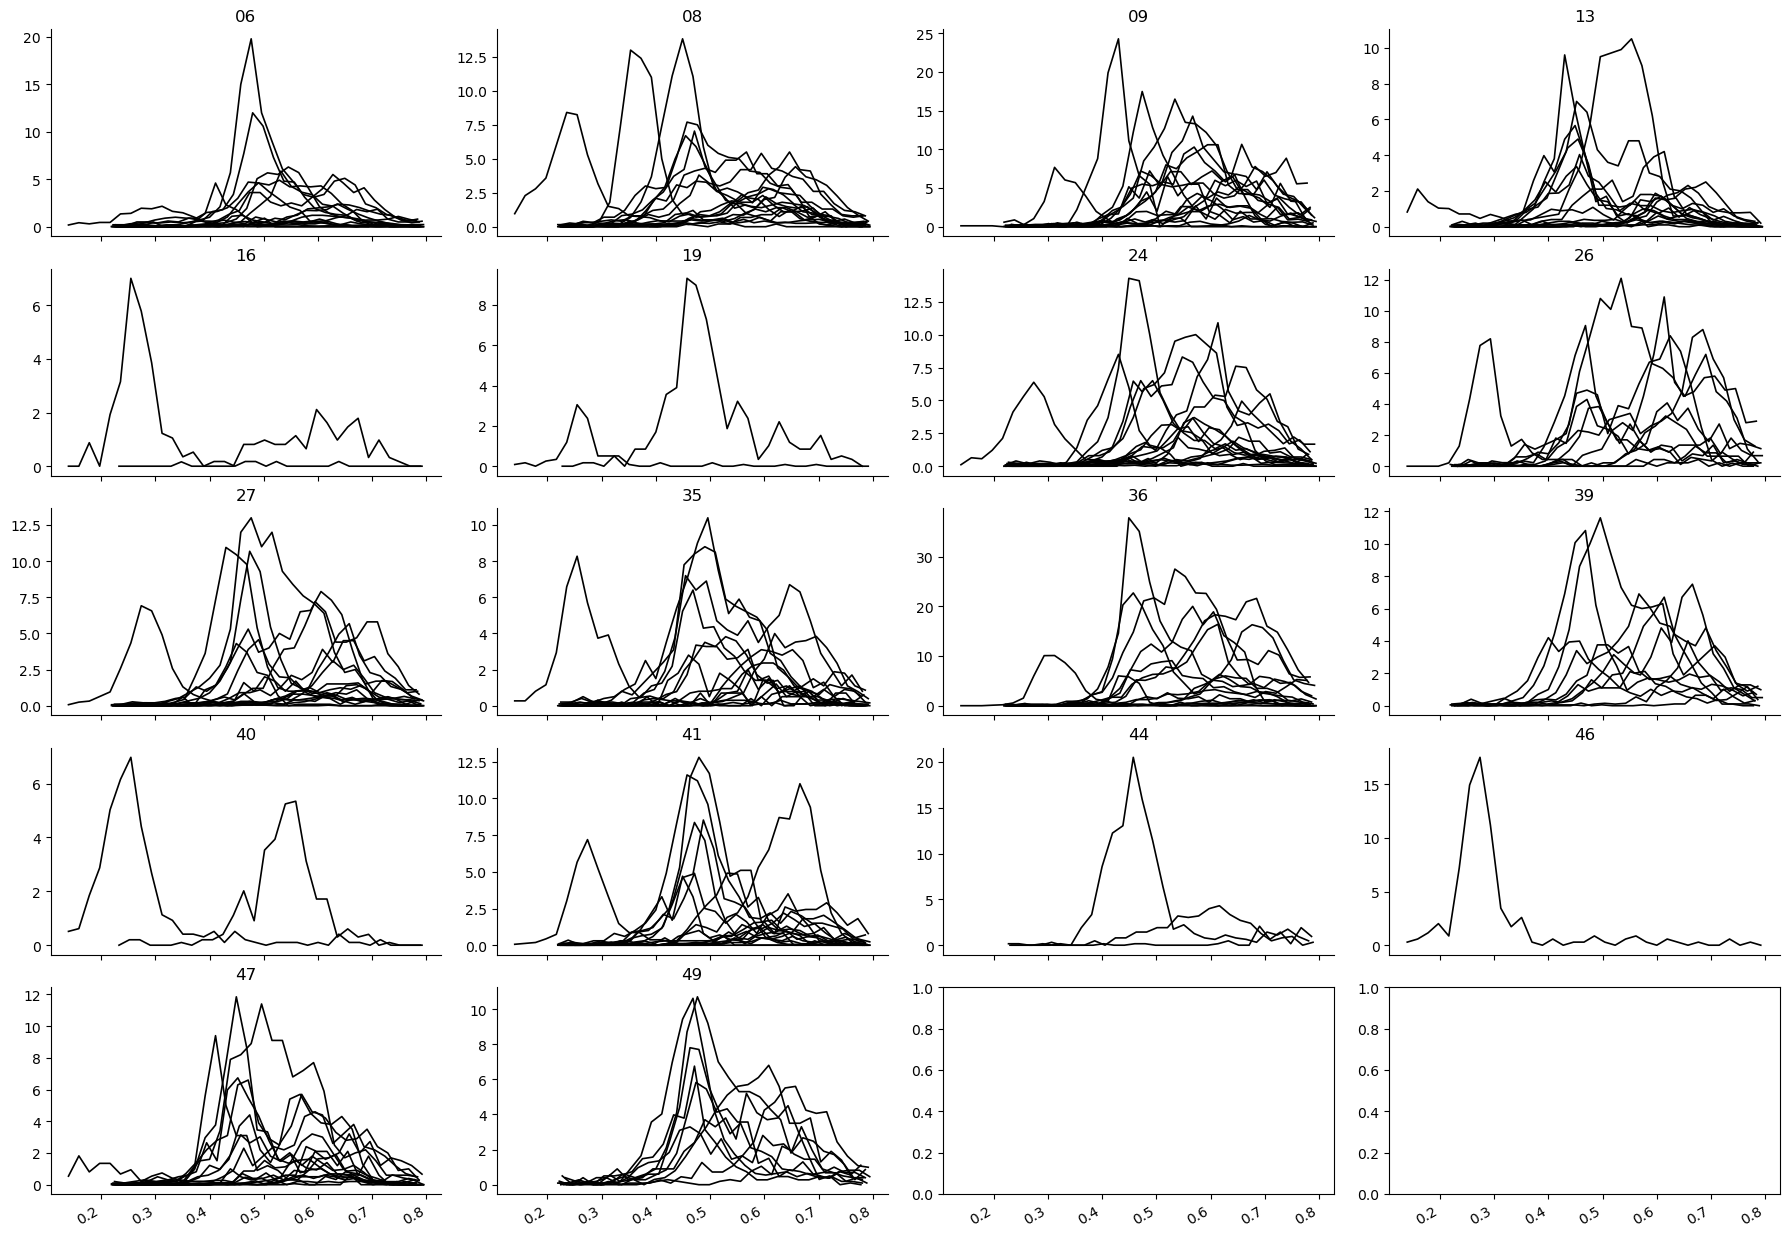

In [17]:
import seaborn as sns
fig, axes = plt.subplots(5, 4, sharex=True, figsize=(18,15))
flusurv_piv = flusurv_clean.pivot(columns='location_code', values='value', index=["fluseason", "fluseason_fraction"])
for idx, pl in enumerate(flusurv_piv.columns):
    for year in flusurv_piv.index.unique(level='fluseason'):
        ax = axes.flat[idx]
        ax.plot(flusurv_piv.loc[year, pl], c='k', lw=1.2)
        ax.set_title(pl)
    #ax.grid()
    sns.despine(ax=ax)
fig.tight_layout()
fig.autofmt_xdate()

## 2. Epidata Fluview
There is also [fluview clinical](https://cmu-delphi.github.io/delphi-epidata/api/fluview_clinical.html) for FluA, FluB, and tested specimen. Which quantity should I look for in this dataset ?

In [14]:
fluview = build_dataset.get_from_epidata(dataset="fluview", season_setup=season_setup, download=download, write=write, clean=False)
fluview

RAW Dataset fluview has 56404 data points, with 55 locations,and NA values: 1, NA locations: 24742


release_date region     issue   epiweek    lag  num_ili  num_patients  \
0       2013-12-31    nat  201352.0  199740.0  847.0    570.0       46842.0   
1       2013-12-31    nat  201352.0  199741.0  846.0    615.0       48023.0   
2       2013-12-31    nat  201352.0  199742.0  845.0    681.0       54961.0   
3       2013-12-31    nat  201352.0  199743.0  844.0    653.0       57044.0   
4       2013-12-31    nat  201352.0  199744.0  843.0    700.0       55506.0   
...            ...    ...       ...       ...    ...      ...           ...   
56399   2022-09-09    jfk  202235.0  202232.0    3.0   1377.0       78674.0   
56400   2022-09-09    jfk  202235.0  202233.0    2.0   1384.0       76378.0   
56401   2022-09-09    jfk  202235.0  202234.0    1.0   1227.0       76349.0   
56402   2022-09-09    jfk  202235.0  202235.0    0.0   1175.0       75781.0   
56403          NaN    NaN       NaN       NaN    NaN      NaN           NaN   

       num_providers  num_age_0  num_age_1  ...  num_age_5      wili  \
0              192.0      179.0      205.0  ...       29.0  1.101483   
1              191.0      199.0      242.0  ...       23.0  1.200068   
2              219.0      228.0      266.0  ...       34.0  1.378763   
3              213.0      188.0      236.0  ...       36.0  1.199199   
4              213.0      217.0      280.0  ...       41.0  1.656178   
...              ...        ...        ...  ...        ...       ...   
56399           26.0        NaN        NaN  ...        NaN  1.750260   
56400           25.0        NaN        NaN  ...        NaN  1.812040   
56401           24.0        NaN        NaN  ...        NaN  1.607090   
56402           21.0        NaN        NaN  ...        NaN  1.550520   
56403            NaN        NaN        NaN  ...        NaN       NaN   

            ili  week_enddate  location_code  location_name abbreviation  \
0      1.216857    1997-10-04            NaN            NaN          NaN   
1      1.280636    1997-10-11            NaN            NaN          NaN   
2      1.239060    1997-10-18            NaN            NaN          NaN   
3      1.144730    1997-10-25            NaN            NaN          NaN   
4      1.261125    1997-11-01            NaN            NaN          NaN   
...         ...           ...            ...            ...          ...   
56399  1.750260    2022-08-13             36       New York           NY   
56400  1.812040    2022-08-20             36       New York           NY   
56401  1.607090    2022-08-27             36       New York           NY   
56402  1.550520    2022-09-03             36       New York           NY   
56403       NaN           NaT             US             US           US   

          value fluseason fluseason_fraction  
0      1.216857    1997.0           0.219178  
1      1.280636    1997.0           0.238356  
2      1.239060    1997.0           0.257534  
3      1.144730    1997.0           0.276712  
4      1.261125    1997.0           0.295890  
...         ...       ...                ...  
56399  1.750260    2022.0           0.076712  
56400  1.812040    2022.0           0.095890  
56401  1.607090    2022.0           0.115068  
56402  1.550520    2022.0           0.134247  
56403       NaN       NaN                NaN  

[56404 rows x 23 columns]

In [15]:
fluview_clean = build_dataset.clean_dataset(fluview, season_setup=season_setup)

 >>> after clean: Dataset 31661 data points, with 53 locations,and NA values: 0, NA locations: 0


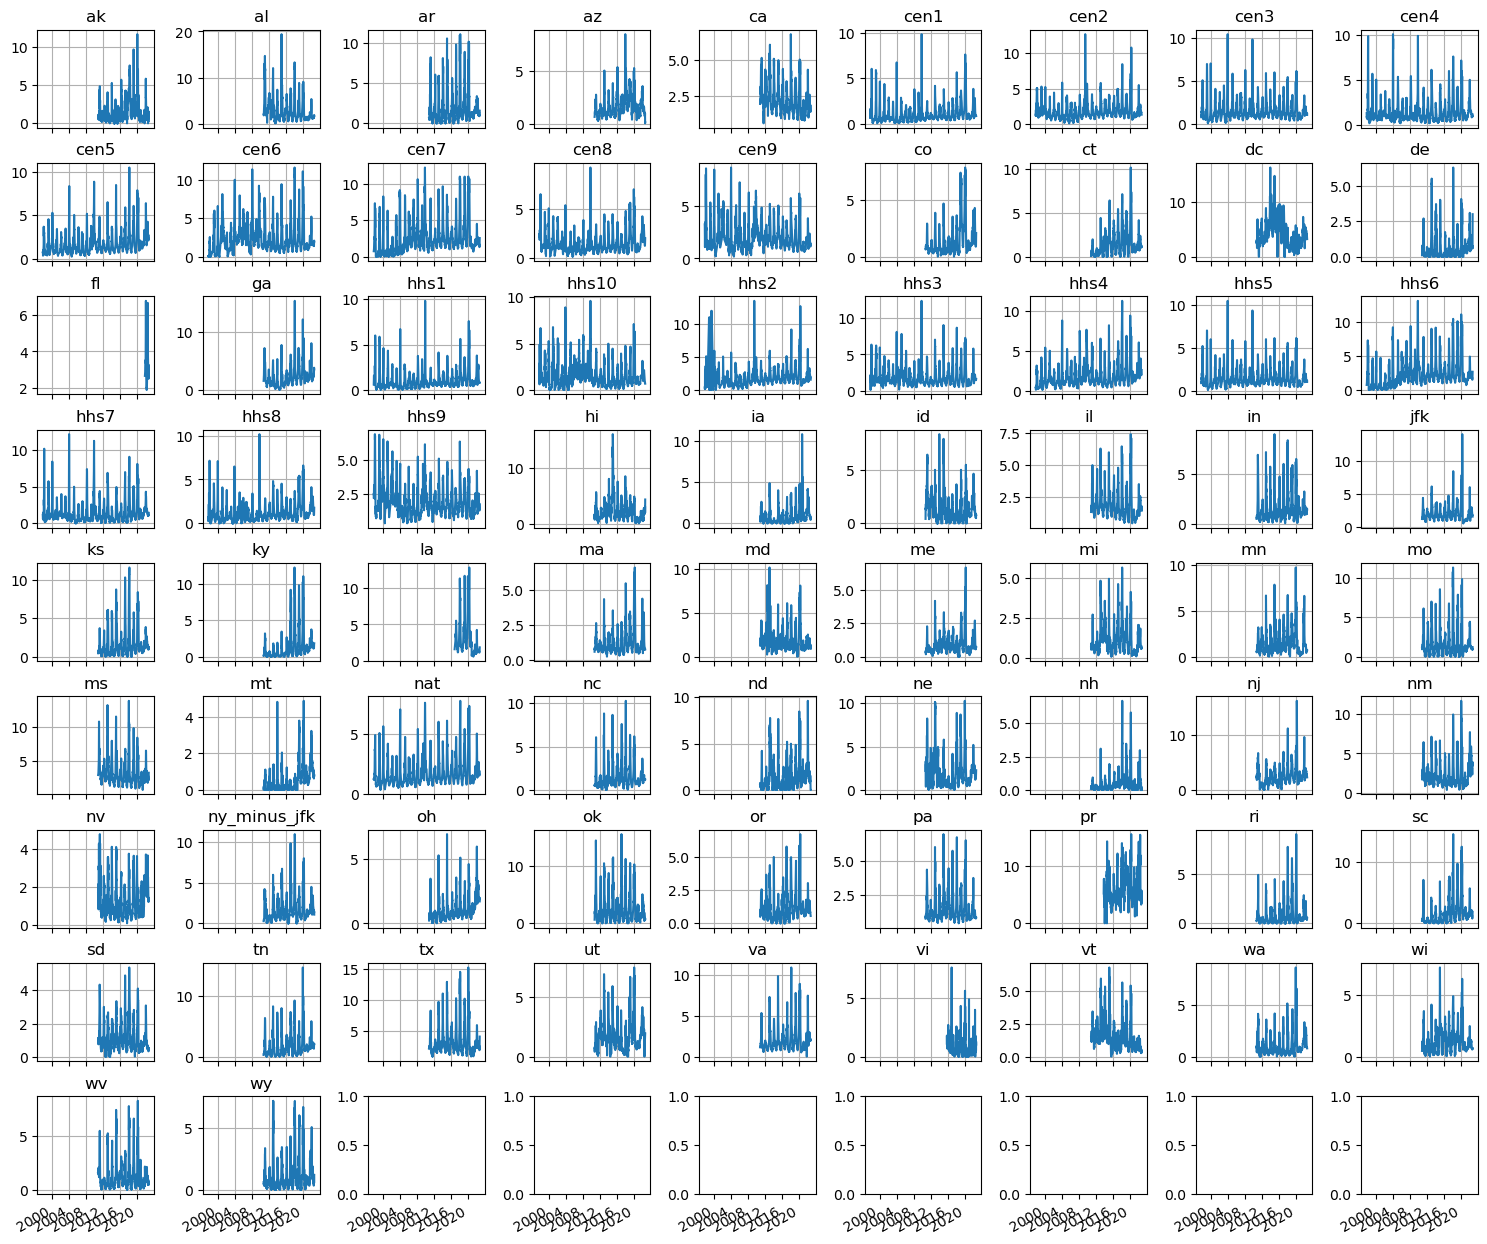

In [17]:
fig, axes = plt.subplots(9, 9, sharex=True, figsize=(15,15))
# remove NA locations
fluview_piv  = fluview[~fluview["region"].isna()].pivot(columns='region', values='ili', index="week_enddate")
for idx, pl in enumerate(fluview_piv.columns):
    ax = axes.flat[idx]
    ax.plot(fluview_piv[pl])
    ax.set_title(pl)#get_location_name(pl))
    ax.grid()
fig.tight_layout()
fig.autofmt_xdate()

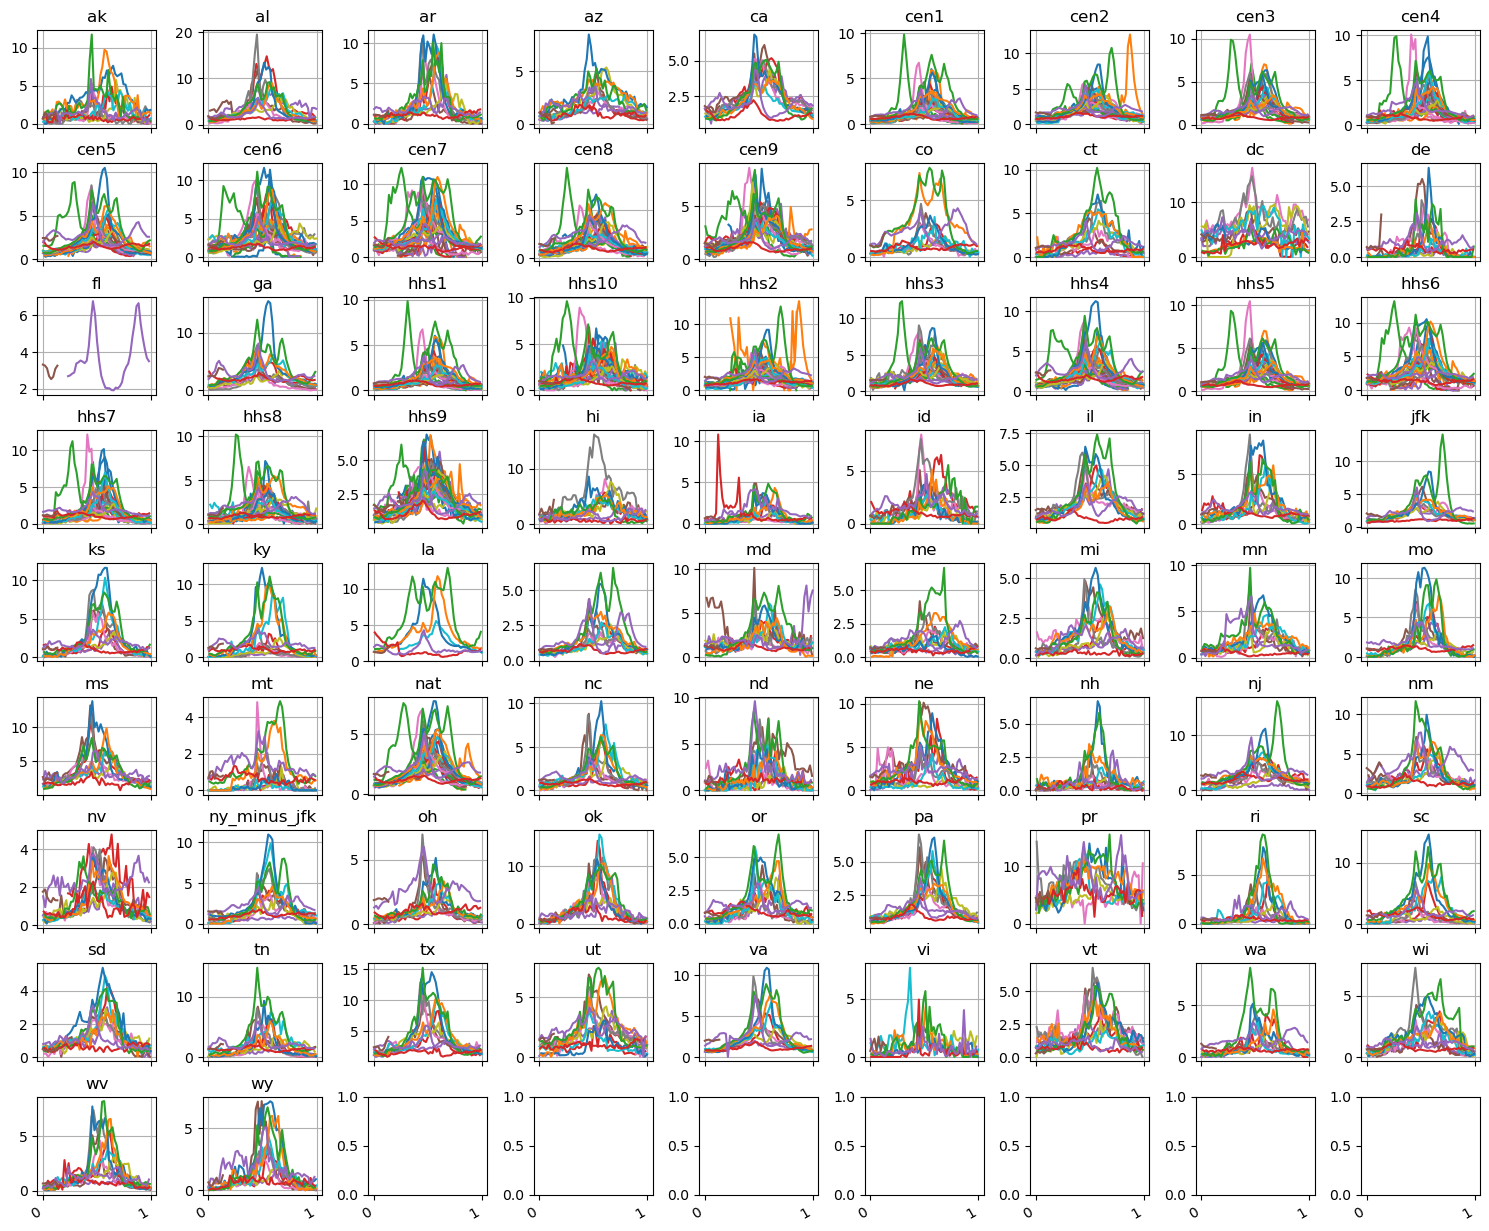

In [20]:
fig, axes = plt.subplots(9, 9, sharex=True, figsize=(15,15))
fluview_piv = fluview[~fluview["region"].isna()].pivot(columns='region', values='ili', index=["fluseason", "fluseason_fraction"])
for idx, pl in enumerate(fluview_piv.columns):
    for year in fluview_piv.index.unique(level='fluseason'):
        ax = axes.flat[idx]
        ax.plot(fluview_piv.loc[year, pl])
        ax.set_title(pl)
    ax.grid()
fig.tight_layout()
fig.autofmt_xdate()

## Merge datasets

In [25]:
for locations_code in season_setup.locations_df.location_code:
    in_fluview, in_flusruv = False, False
    if not flusurv_clean[flusurv_clean['location_code'] == locations_code].empty:
        in_flusruv = True
    if not fluview_clean[fluview_clean['location_code'] == locations_code].empty:
        in_fluview = True
    if in_fluview and in_flusruv:
        suffix = "in both fluview and flusurv"
    elif in_fluview:
        suffix = "in fluview"
    elif in_flusruv:
        suffix = " in flusurv"
    else:
        suffix = "NOT in fluview NOR flusurv"
    print(f"{locations_code}, {season_setup.get_location_name(locations_code):<22} {suffix}")

US, US                     NOT in fluview NOR flusurv
01, Alabama                in fluview
02, Alaska                 in fluview
04, Arizona                in fluview
05, Arkansas               in fluview
06, California             in both fluview and flusurv
08, Colorado               in both fluview and flusurv
09, Connecticut            in both fluview and flusurv
10, Delaware               in fluview
11, District of Columbia   in fluview
12, Florida                in fluview
13, Georgia                in both fluview and flusurv
15, Hawaii                 in fluview
16, Idaho                  in both fluview and flusurv
17, Illinois               in fluview
18, Indiana                in fluview
19, Iowa                   in both fluview and flusurv
20, Kansas                 in fluview
21, Kentucky               in fluview
22, Louisiana              in fluview
23, Maine                  in fluview
24, Maryland               in both fluview and flusurv
25, Massachusetts          in

## 4. FluSurv from Claire and FlepiMoP Team
(min and max from Flu SMH comes from these):
the numbers come from FluSurvNet -- hosp rates taken and multiplied by population
```
[9:49 AM] Prior Peaks: are based on the minimum and maximum observed in national data in the 8 pre-pandemic seasons 2012-2020, converted to state-level estimates.
The estimates for incident are based on weekly peaks, and for cumulative based on cumulative hospitalizations at the end of the season.
```

So on R you do:
```R
source("~/Documents/phd/COVIDScenarioPipeline/Flu_USA/R/groundtruth_functions.R")
flus_surv <- get_flu_groundtruth(source="flusurv_hosp", "2015-10-10", "2022-06-11", age_strat = FALSE, daily = FALSE)
flus_surv %>% write_csv("flu_surv_cspGT.csv")
```

This is the only dataset where the scaling is good

In [31]:
csp_flusurv = pd.read_csv("Flusight/flu-datasets/flu_surv_cspGT.csv", parse_dates=["date"])
df = pd.merge(csp_flusurv, season_setup.locations_df, left_on="FIPS", right_on="abbreviation", how='left')
df["fluseason"]= df["date"].apply(season_setup.get_fluseason_year)
df["fluseason_fraction"]= df["date"].apply(season_setup.get_fluseason_fraction)
df["value"] = df["incidH"]
df["week_enddate"] = df["date"]

csp_flusurv = build_dataset.clean_dataset(df, season_setup=season_setup)
csp_flusurv

 >>> after clean: Dataset 10917 data points, with 51 locations,and NA values: 0, NA locations: 0


week_enddate location_code      value  fluseason  fluseason_fraction
0       2015-10-10            13  10.403847       2015            0.235616
1       2015-10-10            24  12.037696       2015            0.235616
2       2015-10-10            26   9.965265       2015            0.235616
3       2015-10-10            27   0.000000       2015            0.235616
4       2015-10-10            35   0.000000       2015            0.235616
...            ...           ...        ...        ...                 ...
10912   2022-05-14            56   9.242201       2021            0.827397
10913   2022-05-21            56   8.021615       2021            0.846575
10914   2022-05-28            56   6.332997       2021            0.865753
10915   2022-06-04            56   3.886907       2021            0.884932
10916   2022-06-11            56   2.805778       2021            0.904110

[10917 rows x 5 columns]

location_code                       01        02          04        05  \
fluseason fluseason_fraction                                             
2015      0.235616             4.87625  0.737068    0.000000   2.99937   
          0.254795             4.87625  0.737068    1.366010   2.99937   
          0.273973             4.87625  0.737068    3.662585   2.99937   
          0.293151             4.87625  0.000000    7.760613   2.99937   
          0.312329             9.75250  0.737068    4.043409   5.99874   
...                                ...       ...         ...       ...   
2021      0.827397            29.25750  3.158619  112.147315  17.99622   
          0.846575            24.38125  4.352292   97.336403  14.99685   
          0.865753            14.62875  5.475851   76.846260   8.99811   
          0.884932            24.38125  2.351435   47.164756  14.99685   
          0.904110             9.75250  3.545109   34.046059   5.99874   

location_code                         06         08          09        10  \
fluseason fluseason_fraction                                                
2015      0.235616             39.283497   0.000000    7.150148  1.308075   
          0.254795             39.283497   0.000000    3.575074  1.308075   
          0.273973             39.283497   5.610349    0.000000  0.350827   
          0.293151              0.000000   5.610349    0.000000  0.957248   
          0.312329             39.283497   0.000000    3.575074  1.308075   
...                                  ...        ...         ...       ...   
2021      0.827397            157.133988  84.155235  110.827294  6.445143   
          0.846575            235.700982  72.934537   21.450444  5.392661   
          0.865753            314.267976  72.934537   35.750740  4.691006   
          0.884932            117.850491  33.662094   21.450444  4.691006   
          0.904110            196.417485  16.831047    7.150148  2.776510   

location_code                       11          12  ...        46         47  \
fluseason fluseason_fraction                        ...                        
2015      0.235616            0.946548   28.561997  ...  0.000000   6.709356   
          0.254795            0.946548   28.561997  ...  0.870638   6.709356   
          0.273973            0.253865    7.660361  ...  0.000000   6.709356   
          0.293151            0.692683   20.901636  ...  0.870638   6.709356   
          0.312329            0.946548   28.561997  ...  0.870638  13.418712   
...                                ...         ...  ...       ...        ...   
2021      0.827397            4.663829  140.730538  ...  2.226245  40.256136   
          0.846575            3.902233  117.749455  ...  1.113122  33.546780   
          0.865753            3.394502  102.428733  ...  2.226245  20.128068   
          0.884932            3.394502  102.428733  ...  0.556561  33.546780   
          0.904110            2.009136   60.625461  ...  1.113122  13.418712   

location_code                         48         49         50         51  \
fluseason fluseason_fraction                                                
2015      0.235616              0.000000   0.000000   1.248626  11.552988   
          0.254795              5.475597   0.000000   0.624313  11.552988   
          0.273973             14.681332   0.000000   0.000000   3.098525   
          0.293151             31.108125   0.000000   0.000000   8.454463   
          0.312329             16.207853   6.193696   0.624313  11.552988   
...                                  ...        ...        ...        ...   
2021      0.827397            449.538257  18.581088  19.353703  56.923828   
          0.846575            390.169277  15.484240   3.745878  47.628253   
          0.865753            308.035315  15.484240   6.243130  41.431204   
          0.884932            189.058137   9.290544   3.745878  41.431204   
          0.904110            136.472334  18.581088   1.248626  24.522

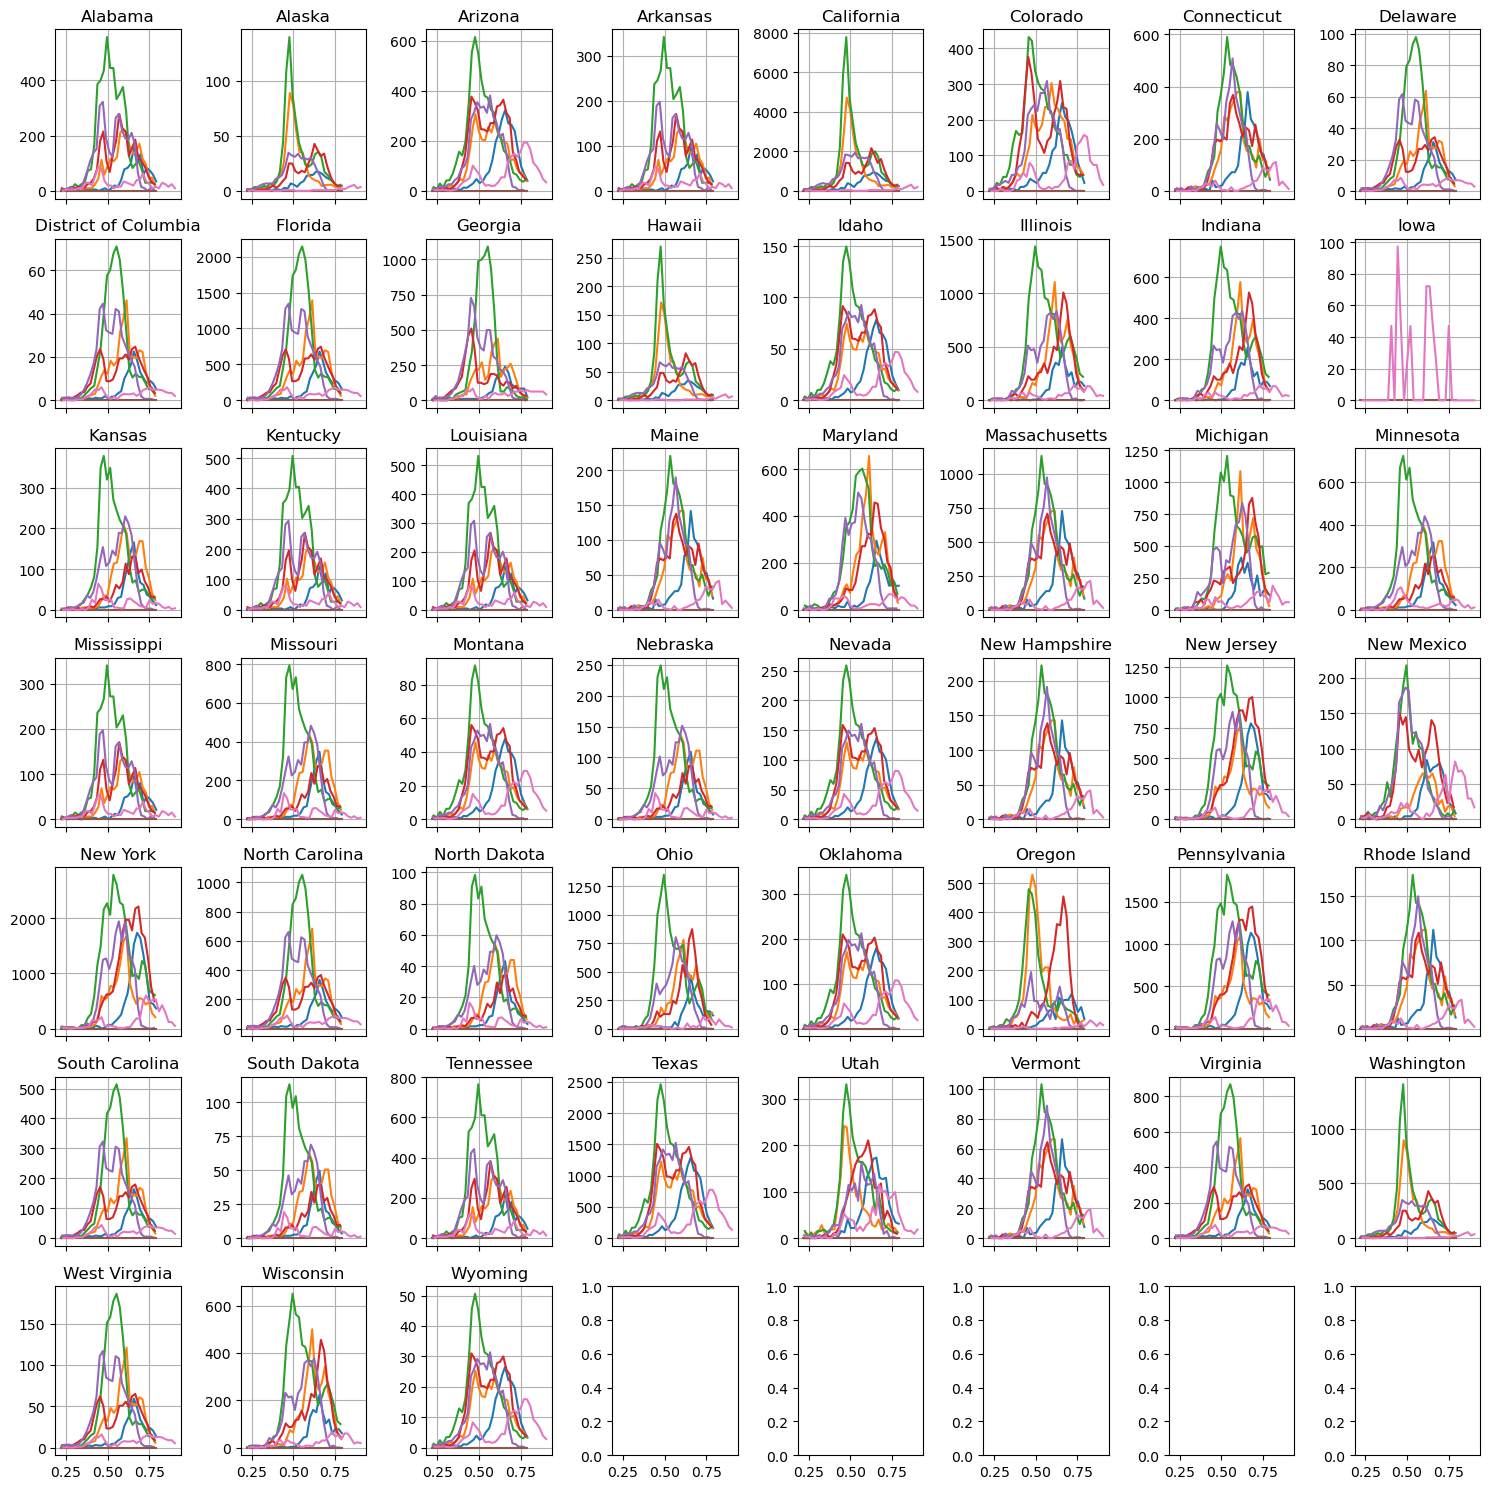

In [36]:
fig, axes = plt.subplots(7, 8, sharex=True, figsize=(15,15))
csp_flusurv_piv = csp_flusurv.pivot(columns='location_code', values='value', index=["fluseason", "fluseason_fraction"])
for idx, pl in enumerate(csp_flusurv_piv.columns):
    for year in csp_flusurv_piv.index.unique(level='fluseason'):
        ax = axes.flat[idx]
        if len(csp_flusurv_piv.loc[year, pl]) > 0:
            ax.plot(csp_flusurv_piv.loc[year, pl])
        else:
            print(f"Empty data for {pl} and year {year}")
        ax.set_title(season_setup.get_location_name(pl))
    ax.grid()
fig.tight_layout()

In [8]:
np.array(build_dataset.dataframe_to_arraylist(df, season_setup = season_setup, value_column='incidH')).shape

(7, 1, 64, 64)

In [11]:
df_piv = df.pivot(columns='location_code', values='incidH', index=["fluseason", "fluseason_fraction"])
for season in df_piv.index.unique(level='fluseason'):
    print(season)

2015
2016
2017
2018
2019
2020
2021


In [12]:
df_piv.loc[season][season_setup.locations]

KeyError: "['72', '78'] not in index"

## Synthetic dataset from CSP

In [37]:
assert False  # stop here when "Run All" is used in this notebook
import gempyor
folder = 'datasets/SMH_R1/'
col2keep = ['incidH_FluA', 'incidH_FluB']

AssertionError: 

Commands to sync Flu SMH R1 from s3 bucket
```bash
aws s3 sync s3://idd-inference-runs/USA-20220923T154311/model_output/ datasets/SMH_R1/SMH_R1_lowVac_optImm_2022 --exclude "*" --include "hosp*/final/*"
aws s3 sync s3://idd-inference-runs/USA-20220923T155228/model_output/ datasets/SMH_R1/SMH_R1_lowVac_pesImm_2022 --exclude "*" --include "hosp*/final/*"
aws s3 sync s3://idd-inference-runs/USA-20220923T160106/model_output/ datasets/SMH_R1/SMH_R1_highVac_optImm_2022 --exclude "*" --include "hosp*/final/*"
aws s3 sync s3://idd-inference-runs/USA-20220923T161418/model_output/ datasets/SMH_R1/SMH_R1_highVac_pesImm_2022 --exclude "*" --include "hosp*/final/*"
```
and take a humidity file from the config


In [45]:
humid = pd.read_csv('datasets/SMH_R1/SMH_R1_lowVac_optImm_2022/r0s_ts_2022-2023.csv', index_col='date', parse_dates=True)

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/SMH_R1/SMH_R1_lowVac_optImm_2022/r0s_ts_2022-2023.csv'

In [ ]:
maxfiles = -1
hosp_files = list(Path(str(folder)).rglob('*.parquet'))[:maxfiles]
df = gempyor.read_df(str(hosp_files[0]))

# To be pasted later
indexes = df[['date', 'geoid']]
full_df = df[['date', 'geoid']] # to
geoids = list(pd.concat([df[col2keep[0]], indexes], axis=1).pivot(values=col2keep[0], index='date', columns='geoid').columns)
dates = list(pd.concat([df[col2keep[0]], indexes], axis=1).pivot(values=col2keep[0], index='date', columns='geoid').index)

In [ ]:
df.columns

In [ ]:
incid_xarr = xr.DataArray(-1 * np.ones((len(hosp_files), 
                           len(col2keep),
                           len(full_df.date.unique()),
                           len(full_df.geoid.unique())
                          )), 
                         coords={'sample': np.arange(len(hosp_files)),'feature': col2keep, 'date': dates, 'place': geoids}, 
                         dims=["sample", "feature", "date", "place"])


for i, path_str in enumerate(hosp_files):
    df = gempyor.read_df(str(path_str))
    data = df[col2keep]
    for k, c in enumerate(col2keep):
        incid_xarr.loc[dict(sample=i, feature=c)] = pd.concat([data[c], indexes], axis=1).pivot(values=c, index='date', columns='geoid').to_numpy()
        

    data.columns = [n+f'_{i}' for n in col2keep]   
    full_df = pd.concat([full_df, data], axis=1)
    

print(int((incid_xarr<0).sum()), f' errors on {i} files')

In [ ]:
humid_st = np.dstack([humid.to_numpy()]*len(hosp_files))
#humid_st = humid_st[:, np.newaxis, :]
print(humid_st.shape)
covar_xarr = xr.DataArray(humid_st, 
                          coords={
                                  #'feature': ['R0Humidity'],
                                  'date': humid.index,
                                  'place': geoids,
                                  'sample': np.arange(len(hosp_files)),}, 
                          dims=[ "date", "place", "sample"]) #"feature",
covar_xarr = covar_xarr.expand_dims({"feature":['R0Humidity']})

### makes the dates of r0 and humidity match

In [ ]:
print(type(incid_xarr), incid_xarr.date[0], incid_xarr.date[-1] )
print(type(covar_xarr), covar_xarr.date[0], covar_xarr.date[-1])

In [ ]:
full_xarr = xr.concat([incid_xarr,covar_xarr], dim="feature", join="inner")

In [ ]:
grid = (1,4)
fig, axes = plt.subplots(grid[0], grid[1], sharex=True, sharey=True, figsize=(grid[1]*2,grid[0]*2))
for i, ax in enumerate(axes.flat):
    c = ['red', 'green', 'blue']
    place = full_xarr.get_index('place')[i]
    tp = full_xarr.sel(place=place)
    for k, val in enumerate(full_xarr.feature):
        ax.plot(tp.date, tp.sel(feature=val).T, c = c[k], lw = .1, alpha=.5)
        ax.plot(tp.date, tp.sel(feature=val).T.median(axis=1), 
                c = 'k',#'dark'+c[k], 
                lw = .5, 
                alpha=1)
    ax.grid()
    ax.set_title(place)
fig.autofmt_xdate()
fig.tight_layout()

In [ ]:
full_xarr_w = full_xarr.resample(date="W").sum()
full_xarr_w

In [ ]:
full_xarr_w_padded = full_xarr_w.pad({'date': (0, 17), 'place':(0,13)}, mode='constant', constant_values=0)
print(full_xarr_w_padded.shape)
full_xarr_w_padded.to_netcdf("datasets/synthetic/CSP_FluSMHR1_weekly_padded_4scn.nc")

## Data from the trajectories submitted to SMH

In [6]:
maxfiles = -1
folder = "Flusight/Flu-SMH/data-processed/"
# Just the last round, submitted on 2023-09-03, contains trajectories
hosp_files = list(Path(str(folder)).rglob('*2023-09-03*.parquet'))[:maxfiles]
print(len(hosp_files), [str(m).split("-")[-1].split(".")[0] for m in hosp_files])

import gempyor

df = gempyor.read_df(str(hosp_files[0]))


13 ['Ensemble', 'FluD', 'ImmunoSEIRS', 'SIkJalpha', 'FRED', 'Ensemble_LOP_untrimmed', 'FluXSim', 'Flu_TS', 'FluCAT', 'GLEAM_FLU', 'FluCompModel', 'MyModel', 'Ensemble_LOP']


In [7]:
big_df = []
for m in hosp_files:
    df = gempyor.read_df(str(m))
    df["model"] = str(m).split("-")[-1].split(".")[0]
    big_df.append(df)
big_df = pd.concat(big_df)

big_df = big_df[(big_df["output_type"] == "sample") & (big_df["target"] == "inc hosp") &  (big_df["age_group"] == "0-130")].reset_index(drop=True)

In [8]:
big_df["week_enddate"] = pd.to_datetime(big_df["origin_date"]) + pd.to_timedelta(big_df["horizon"], unit='W')
big_df["location_code"] = big_df["location"]
big_df = big_df.drop(columns=["origin_date", "horizon", "target", "output_type", "age_group", "location"])
big_df

scenario_id        value output_type_id    model week_enddate  \
0        F-2023-08-14  2049.591184            1.0     FluD   2023-09-10   
1        F-2023-08-14  2271.739094            2.0     FluD   2023-09-10   
2        F-2023-08-14  2181.617486            3.0     FluD   2023-09-10   
3        F-2023-08-14  2150.565128            4.0     FluD   2023-09-10   
4        F-2023-08-14  1498.881722            5.0     FluD   2023-09-10   
...               ...          ...            ...      ...          ...   
6575395  B-2023-08-14   587.861200            100  MyModel   2024-06-02   
6575396  C-2023-08-14  5766.461500            100  MyModel   2024-06-02   
6575397  D-2023-08-14   163.158400            100  MyModel   2024-06-02   
6575398  E-2023-08-14  4198.119000            100  MyModel   2024-06-02   
6575399  F-2023-08-14  3805.608200            100  MyModel   2024-06-02   

        location_code  
0                  US  
1                  US  
2                  US  
3                  US  
4                  US  
...               ...  
6575395            56  
6575396            56  
6575397            56  
6575398            56  
6575399            56  

[6575400 rows x 6 columns]

In [46]:
this_traj

location_code         01         02         04         05         06  \
week_enddate                                                           
2023-09-10      780.8705  4154.2421    85.0981  4359.2210  5403.1296   
2023-09-17     3076.5044  5995.9466  3048.6445  4276.9154  3779.8891   
2023-09-24     5973.7296  2667.6150  4632.0479  4821.5667  1610.1503   
2023-10-01     5007.5307   190.9970  5315.9404  3967.9940  5746.8480   
2023-10-08     3215.1139   397.9452  1126.3625  5671.2627  3297.8470   
2023-10-15     2822.8941  2836.1362  5392.2701  2385.4478    31.1244   
2023-10-22      783.2645  1593.4310  5582.1015  1865.3258   149.9243   
2023-10-29     1250.9377  5783.8463  5804.4929  3504.2675  3755.5206   
2023-11-05     4123.5314  5562.5843  1090.3291  2847.8365  2835.6442   
2023-11-12     5027.7829  1020.5817  2882.1248  1049.1179  3048.5195   
2023-11-19     5438.7372  4260.7531  1407.4345   163.0800  5821.1329   
2023-11-26      237.8243  4820.6889  5674.3654  2400.2842  4533.8967   
2023-12-03     1648.7180  4357.8426  4933.4793  3118.2156    62.0033   
2023-12-10      202.7079  1130.9545  3651.8752  4922.6761  5519.3671   
2023-12-17      714.0147  4442.3981  4720.5906  5425.4424  1592.2340   
2023-12-24     5463.9369  5066.3838  3773.4452  5891.7564   734.8496   
2023-12-31      278.6222   230.4415   370.9615  1450.0912  2583.8593   
2024-01-07     5242.2570  4280.3928  5799.1269   627.9966  2342.3412   
2024-01-14     4024.4539  5090.6541   158.0327  1959.8444  2622.4381   
2024-01-21     2319.1244  3264.2652  1123.2129  5836.9835  4996.2447   
2024-01-28     1552.9188   459.4194  4102.6472  2414.6232  5422.1141   
2024-02-04     5255.3313  4362.6337   759.9415   312.0354  5352.6617   
2024-02-11     1482.4168  2910.9585  1098.6093  5991.5182    10.6352   
2024-02-18      395.0168  5772.6336  1296.4513  3346.4966  5459.9893   
2024-02-25     2135.2867  1393.9873  4312.5473  2564.1145  2132.4911   
2024-03-03     3143.4352  5202.0744  4189.5973  3848.6814  4689.5838   
2024-03-10     2302.9456  1872.2740   948.0328  5611.0190  2172.5166   
2024-03-17     5495.1234  4559.0569  5516.2863  1741.0375  5193.5258   
2024-03-24     1162.5521   507.8818  2567.7592  4590.5454   365.6686   
2024-03-31      801.4397  2063.1957  5424.8335  5989.4254  1817.4379   
2024-04-07     2164.5708  3980.2756  5359.4262   954.5550  3181.2277   
2024-04-14     5015.0668  4412.0202  5004.5310  1126.1765  2904.5720   
2024-04-21     4598.9615  3402.2183   248.0650  2089.9430  4896.4347   
2024-04-28     5218.9081   735.9317  1491.9739  3085.5562  5908.9098   
2024-05-05      966.1240  2924.5214  1624.8710   687.3071  5698.2717   
2024-05-12      682.9595  3873.4069  5806.4905  4458.0534  3612.3826   
2024-05-19     2929.3030  5064.6449   847.9427  4853.9549  2821.9400   
2024-05-26      770.9297  3354.9847  3496.4671  3300.8460  3901.3135   
2024-06-02       72.6051  3229.5483   946.3842  4430.2247  5216.8904   

location_code         08         09         10         11         12  ...  \
week_enddate                                                          ...   
2023-09-10     5804.9979  4280.8248  5680.7104  3807.1573    76.5978  ...   
2023-09-17     2588.3160  2763.1230  5891.3251  2413.0012  1200.0153  ...   
2023-09-24      876.5637  1591.3323   231.4034   140.9123  2680.5959  ...   
2023-10-01     4121.0172  4910.6876  5071.5464  1222.6862  5244.3083  ...   
2023-10-08     5972.3980  5673.1609   813.2830  2364.1967  2348.1965  ...   
2023-10-15     2121.4460  2891.9721  3846.3143  3094.0964  1024.3140  ...   
2023-10-22     2954.7864  1614.2595  5982.1491  3849.7397  4496.7805  ...   
2023-10-29     5600.4255  1441.9166  2881.9589  4050.4375  4064.0972  ...   
2023-11-05     1637.8007    37.5317   418.3401  2230.6873  3484.6982  ...   
2023-11-12     2179.2067  4168.9066  4363.1329  4744.6017   497.4048  ...   
2023-11-19       76.1243   147.3161  1489.5622   734.3974  1405.6657  ...   
2023-11-26      190.5160  2698.6240   184.6388

In [51]:
a = this_df[this_df["output_type_id"] == traj]
a = a.assign(season_fraction=a["week_enddate"].apply(season_setup.get_fluseason_fraction))
a = a.assign(season=a["week_enddate"].apply(season_setup.get_fluseason_year))
a = a.assign(epiweek=a["week_enddate"].apply(lambda x: epiweeks.Week.fromdate(x).week))

In [71]:
# There are either 52 [1 to 53] epiweeks or 51 epiweeks [1 to 51] in a year
index = [epiweeks.Week.fromdate(d).week for d in season_setup.get_dates()] # has 53 weeks
assert len(index) == 52  # the index year has 52 weeks (1 to 53)

In [70]:
index

[29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27]

In [66]:
index

0     29
1     30
2     31
3     32
4     33
5     34
6     35
7     36
8     37
9     38
10    39
11    40
12    41
13    42
14    43
15    44
16    45
17    46
18    47
19    48
20    49
21    50
22    51
23    52
24    53
25     1
26     2
27     3
28     4
29     5
30     6
31     7
32     8
33     9
34    10
35    11
36    12
37    13
38    14
39    15
40    16
41    17
42    18
43    19
44    20
45    21
46    22
47    23
48    24
49    25
50    26
51    27
dtype: int64

In [65]:
if max(a.epiweek) < 53:
    # drop the week number 53 in the middle of the INDEX
    index_mod = index.drop(53, axis=0)
else:
    index_mod = index
index_mod

KeyError: '[53] not found in axis'

In [56]:
import pandas as pd
a_piv = a.pivot(columns='location_code', values='value', index="epiweek")
a_piv

location_code         01         02         04         05         06  \
epiweek                                                                
1               278.6222   230.4415   370.9615  1450.0912  2583.8593   
2              5242.2570  4280.3928  5799.1269   627.9966  2342.3412   
3              4024.4539  5090.6541   158.0327  1959.8444  2622.4381   
4              2319.1244  3264.2652  1123.2129  5836.9835  4996.2447   
5              1552.9188   459.4194  4102.6472  2414.6232  5422.1141   
6              5255.3313  4362.6337   759.9415   312.0354  5352.6617   
7              1482.4168  2910.9585  1098.6093  5991.5182    10.6352   
8               395.0168  5772.6336  1296.4513  3346.4966  5459.9893   
9              2135.2867  1393.9873  4312.5473  2564.1145  2132.4911   
10             3143.4352  5202.0744  4189.5973  3848.6814  4689.5838   
11             2302.9456  1872.2740   948.0328  5611.0190  2172.5166   
12             5495.1234  4559.0569  5516.2863  1741.0375  5193.5258   
13             1162.5521   507.8818  2567.7592  4590.5454   365.6686   
14              801.4397  2063.1957  5424.8335  5989.4254  1817.4379   
15             2164.5708  3980.2756  5359.4262   954.5550  3181.2277   
16             5015.0668  4412.0202  5004.5310  1126.1765  2904.5720   
17             4598.9615  3402.2183   248.0650  2089.9430  4896.4347   
18             5218.9081   735.9317  1491.9739  3085.5562  5908.9098   
19              966.1240  2924.5214  1624.8710   687.3071  5698.2717   
20              682.9595  3873.4069  5806.4905  4458.0534  3612.3826   
21             2929.3030  5064.6449   847.9427  4853.9549  2821.9400   
22              770.9297  3354.9847  3496.4671  3300.8460  3901.3135   
23               72.6051  3229.5483   946.3842  4430.2247  5216.8904   
37              780.8705  4154.2421    85.0981  4359.2210  5403.1296   
38             3076.5044  5995.9466  3048.6445  4276.9154  3779.8891   
39             5973.7296  2667.6150  4632.0479  4821.5667  1610.1503   
40             5007.5307   190.9970  5315.9404  3967.9940  5746.8480   
41             3215.1139   397.9452  1126.3625  5671.2627  3297.8470   
42             2822.8941  2836.1362  5392.2701  2385.4478    31.1244   
43              783.2645  1593.4310  5582.1015  1865.3258   149.9243   
44             1250.9377  5783.8463  5804.4929  3504.2675  3755.5206   
45             4123.5314  5562.5843  1090.3291  2847.8365  2835.6442   
46             5027.7829  1020.5817  2882.1248  1049.1179  3048.5195   
47             5438.7372  4260.7531  1407.4345   163.0800  5821.1329   
48              237.8243  4820.6889  5674.3654  2400.2842  4533.8967   
49             1648.7180  4357.8426  4933.4793  3118.2156    62.0033   
50              202.7079  1130.9545  3651.8752  4922.6761  5519.3671   
51              714.0147  4442.3981  4720.5906  5425.4424  1592.2340   
52             5463.9369  5066.3838  3773.4452  5891.7564   734.8496   

location_code         08         09         10         11         12  ...  \
epiweek                                                               ...   
1              1401.5097  5760.2187  3043.7788  4506.1266  4440.7359  ...   
2              2959.7924  2283.0223  1550.2930  5706.3243  1914.8983  ...   
3              5602.0968  4792.5900  4394.5658  4155.1359   318.3455  ...   
4              4880.5321  4861.7999   386.5881  5655.6871  3451.7615  ...   
5              4926.3929  2532.2604  3425.3749  5045.0730  3653.6759  ...   
6              1875.9175   435.0548  3103.3536  5771.4738  5898.8618  ...   
7              2945.9836  5503.8040  4824.0642  2466.9023    12.6348  ...   
8              4342.7596  4870.5182  3772.8125   276.8017  1930.1852  ...   
9              5772.3701  3205.5276  4311.3056  5098.3251  2224.8470  ...   
10             5720.1304  2360.2062  1966.6410  1069.9633  5354.8446  ...   
11             5966.9557  3818.2925  5937.1745  4397.8421  3287.8600  ...   
12              475.4621   355.0371   802.4295

In [57]:
# reindex a_piv with a_piv.index = index, using the closest value and zeros for missing values
a_piv = a_piv.reindex(index, fill_value=0)
a_piv

location_code         01         02         04         05         06  \
29                0.0000     0.0000     0.0000     0.0000     0.0000   
30                0.0000     0.0000     0.0000     0.0000     0.0000   
31                0.0000     0.0000     0.0000     0.0000     0.0000   
32                0.0000     0.0000     0.0000     0.0000     0.0000   
33                0.0000     0.0000     0.0000     0.0000     0.0000   
34                0.0000     0.0000     0.0000     0.0000     0.0000   
35                0.0000     0.0000     0.0000     0.0000     0.0000   
36                0.0000     0.0000     0.0000     0.0000     0.0000   
37              780.8705  4154.2421    85.0981  4359.2210  5403.1296   
38             3076.5044  5995.9466  3048.6445  4276.9154  3779.8891   
39             5973.7296  2667.6150  4632.0479  4821.5667  1610.1503   
40             5007.5307   190.9970  5315.9404  3967.9940  5746.8480   
41             3215.1139   397.9452  1126.3625  5671.2627  3297.8470   
42             2822.8941  2836.1362  5392.2701  2385.4478    31.1244   
43              783.2645  1593.4310  5582.1015  1865.3258   149.9243   
44             1250.9377  5783.8463  5804.4929  3504.2675  3755.5206   
45             4123.5314  5562.5843  1090.3291  2847.8365  2835.6442   
46             5027.7829  1020.5817  2882.1248  1049.1179  3048.5195   
47             5438.7372  4260.7531  1407.4345   163.0800  5821.1329   
48              237.8243  4820.6889  5674.3654  2400.2842  4533.8967   
49             1648.7180  4357.8426  4933.4793  3118.2156    62.0033   
50              202.7079  1130.9545  3651.8752  4922.6761  5519.3671   
51              714.0147  4442.3981  4720.5906  5425.4424  1592.2340   
52             5463.9369  5066.3838  3773.4452  5891.7564   734.8496   
53                0.0000     0.0000     0.0000     0.0000     0.0000   
1               278.6222   230.4415   370.9615  1450.0912  2583.8593   
2              5242.2570  4280.3928  5799.1269   627.9966  2342.3412   
3              4024.4539  5090.6541   158.0327  1959.8444  2622.4381   
4              2319.1244  3264.2652  1123.2129  5836.9835  4996.2447   
5              1552.9188   459.4194  4102.6472  2414.6232  5422.1141   
6              5255.3313  4362.6337   759.9415   312.0354  5352.6617   
7              1482.4168  2910.9585  1098.6093  5991.5182    10.6352   
8               395.0168  5772.6336  1296.4513  3346.4966  5459.9893   
9              2135.2867  1393.9873  4312.5473  2564.1145  2132.4911   
10             3143.4352  5202.0744  4189.5973  3848.6814  4689.5838   
11             2302.9456  1872.2740   948.0328  5611.0190  2172.5166   
12             5495.1234  4559.0569  5516.2863  1741.0375  5193.5258   
13             1162.5521   507.8818  2567.7592  4590.5454   365.6686   
14              801.4397  2063.1957  5424.8335  5989.4254  1817.4379   
15             2164.5708  3980.2756  5359.4262   954.5550  3181.2277   
16             5015.0668  4412.0202  5004.5310  1126.1765  2904.5720   
17             4598.9615  3402.2183   248.0650  2089.9430  4896.4347   
18             5218.9081   735.9317  1491.9739  3085.5562  5908.9098   
19              966.1240  2924.5214  1624.8710   687.3071  5698.2717   
20              682.9595  3873.4069  5806.4905  4458.0534  3612.3826   
21             2929.3030  5064.6449   847.9427  4853.9549  2821.9400   
22              770.9297  3354.9847  3496.4671  3300.8460  3901.3135   
23               72.6051  3229.5483   946.3842  4430.2247  5216.8904   
24                0.0000     0.0000     0.0000     0.0000     0.0000   
25                0.0000     0.0000     0.0000     0.0000     0.0000   
26                0.0000     0.0000     0.0000     0.0000     0.0000   
27                0.0000     0.0000     0.0000     0.0000     0.0000   

location_code         08         09         10         11         12  ...  \
29                0.0000     0.0000     0.0000     0.0000     0.0000  ...   
30                0.0000     

In [9]:
array_list = []

gleam = big_df[(big_df["model"]=="GLEAM_FLU")& (big_df["location_code"] == "11")]

for m in big_df.model.unique():
    if len(big_df[(big_df["model"]==m)].location_code.unique()) > 45: # a lot have smaller than 51 locations (just US, just CA), and one has 57 location...
        print(len(big_df[(big_df["model"]==m)].location_code.unique()), m)
        for scn in big_df.scenario_id.unique():
            this_df =  big_df[(big_df["scenario_id"] == scn) & (big_df["model"]==m)]
            for traj in this_df.output_type_id.unique():
                this_traj = this_df[this_df["output_type_id"] == traj].pivot(index="week_enddate", columns='location_code', values='value')
                
                if m == "ImmunoSEIRS": # this model does not have washington DC (11)
                    # replacet it with GLEAM_FLU
                    gleam11 = gleam[(gleam["scenario_id"] == scn) 
                                    & (gleam["output_type_id"] == traj)].pivot(index="week_enddate", columns='location_code', values='value')
                    this_traj["11"] = gleam11
                
                # re-order the locations and keep these in season_setup
                this_traj = this_traj[season_setup.locations]
        
                # order the dates
                this_traj = this_traj.sort_index()
                
                array_list.append(this_traj.to_numpy())

51 ImmunoSEIRS
57 SIkJalpha
52 FRED
52 GLEAM_FLU
52 MyModel


In [95]:
flu_smh = np.array(array_list)
# add the feature dimention
flu_smh = flu_smh[:, np.newaxis, :]

In [97]:
flu_smh_xarr = xr.DataArray(flu_smh, 
                coords={'sample': np.arange(flu_smh.shape[0]),
                    'feature': np.arange(flu_smh.shape[1]),
                    'date': this_traj.index,
                    'place': season_setup.locations}, 
                dims=["sample", "feature", "date", "place"])


IndexError: too many indices for array